In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau, linregress
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score,explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor

import xgboost as xgb

import datarobot as dr

import json

import joblib

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Helper Functions

In [2]:
def combine_years(base_file_name, years): # for when all of one year is in a dataframe
    df_all = pd.DataFrame()
    for yr in years:
        filename = base_file_name.replace('YYYY', str(yr))
        df = pd.read_csv(filename)
        df_all = pd.concat([df_all, df], axis=0).reset_index(drop=True)
    return df_all

In [3]:
def combine_per_fire_csv(ids, prefix, str_check): #for when a variable is split by fire, takes a list of irwinids
    df_all = pd.DataFrame()
    for i_d in ids:
        for fname in os.listdir(prefix):
            if fname.startswith(i_d) & (str_check in fname):
                df_fire = pd.read_csv(prefix+fname)
                df_all = pd.concat([df_all, df_fire], axis=0).reset_index(drop=True)
    return df_all

In [4]:
def add_to_features(feats, data_to_add): #feats has the multi index of irwinID, day
    #multiindex = data_to_add.set_index(['irwinID', 'day'])
    feats = pd.merge(feats, data_to_add, how='inner', on=['irwinID', 'day']).drop(columns='Unnamed: 0')
    return feats

In [5]:
def generate_feature_vector(years, is_weighted, features_to_use):
    if 'rave' in features_to_use:
        rave = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_RAVE_Unweighted_12Z_day_start.csv', years)
        print('rave', len(rave))
        features = rave[['irwinID','day']].set_index(['irwinID', 'day'])
        features = add_to_features(features, rave).drop_duplicates()
        
    if 'fre' in features_to_use:
        fre = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_fre/', is_weighted)
        print('fre', len(fre))
        features = add_to_features(features, fre).drop_duplicates()
        
    if 'hwp' in features_to_use:
        hwp = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hwp/', is_weighted)
        print('hwp', len(hwp))
        features = add_to_features(features, hwp).drop_duplicates()
    
    if 'hrrr_moisture' in features_to_use:
        hrrr_moisture = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hrrr_moisture/', is_weighted)
        print('hrrr_moisture', len(hrrr_moisture))
        features = add_to_features(features, hrrr_moisture).drop_duplicates()
        
    if 'hdw500' in features_to_use:
        hdw500 = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_hdw500/', is_weighted)
        print('hdw500', len(hdw500))
        features = add_to_features(features, hdw500).drop_duplicates()

    if 'hdw' in features_to_use:
        hdw = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HDW_'+is_weighted+'_12Z_day_start.csv', years)
        print('hdw', len(hdw))
        features = add_to_features(features, hdw).drop_duplicates()
        
    if 'resources' in features_to_use:
        """resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources/', '')"""
        resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources_split/', '')
        print('resources', len(resources))
        features = add_to_features(features, resources).drop_duplicates()
        
    if 'pft' in features_to_use:
        pft = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pft/', is_weighted)
        print('pft', len(pft))
        features = add_to_features(features, pft).drop_duplicates()
        
    if 'smops' in features_to_use:
        smops = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SMOPS_'+is_weighted+'_12Z_day_start.csv', years)
        print('smops', len(smops))
        features = add_to_features(features, smops).drop_duplicates()

    if 'imerg' in features_to_use:
        imerg = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_IMERG_FWI_'+is_weighted+'_12Z_day_start.csv', years)
        print('imerg', len(imerg))
        features = add_to_features(features, imerg).drop_duplicates()

    if 'pws' in features_to_use:
        pws = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_PWS_'+is_weighted+'_12Z_day_start.csv', years)
        print('pws', len(pws))
        features = add_to_features(features, pws).drop_duplicates()
        
    if 'loading' in features_to_use:
        loading = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_LOADING_'+is_weighted+'_12Z_day_start.csv', years)
        print('loading', len(loading))
        features = add_to_features(features, loading).drop_duplicates()
        

    if 'ncar' in features_to_use:
        ncar = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_ncar/', is_weighted)
        print('ncar', len(ncar))
        features = add_to_features(features, ncar).drop_duplicates()

    
    if 'esi' in features_to_use:
        esi = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_esi/', is_weighted)
        print('esi', len(esi))
        features = add_to_features(features, esi).drop_duplicates()
        
    if 'chi' in features_to_use:
        chi_2019 = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_CHI_'+is_weighted+'_12Z_day_start.csv', years)
        chi_2020 = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_chi/', is_weighted)
        chi= pd.concat([chi_2019, chi_2020], axis=0).reset_index(drop=True)
        print('chi', len(chi))
        features = add_to_features(features, chi).drop_duplicates()
        
    if 'pop' in features_to_use:
        pop = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pop/', is_weighted)
        print('pop', len(pop))
        features = add_to_features(features, pop).drop_duplicates()
        
    if 'structures' in features_to_use:
        structures = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_structures/', '')
        print('structures', len(structures))
        features = add_to_features(features, structures).drop_duplicates()
        
    if 'gridmet' in features_to_use:
        gridmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_gridmet/',is_weighted)
        gridmet= gridmet.rename({'wind_speed': 'wind_speed_gridmet','mean_vapor_pressure_deficit':'vpd_gridmet'}, axis='columns')
        print('gridmet', len(gridmet))
        features = add_to_features(features, gridmet).drop_duplicates()
        
    if 'slope' in features_to_use:
        slope = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_slope/',is_weighted)
        print('slope', len(slope))
        features = add_to_features(features, slope).drop_duplicates()
        
    if 'elevation' in features_to_use:
        elevation = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_elevation/',is_weighted)
        print('elevation', len(elevation))
        features = add_to_features(features, elevation).drop_duplicates()
        
    if 'heatwave' in features_to_use:
        heatwave = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_heatwave/','')
        print('heatwave', len(heatwave))
        features = add_to_features(features, heatwave).drop_duplicates()
        
    if 'hrrrmet' in features_to_use:
        hrrrmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_hrrrmet/',is_weighted)
        hrrrmet= hrrrmet.rename({'wind_speed': 'wind_speed_hrrrmet','vpd_2m':'vpd_hrrrmet'}, axis='columns')
        print('hrrrmet', len(hrrrmet))
        features = add_to_features(features, hrrrmet).drop_duplicates()
        
    return features


In [6]:
def find_outliers(df, col_name):
    quantiles = df[col_name].quantile(q=[.25, .5, .75])
    print(quantiles)
    iqr = quantiles[0.75]-quantiles[0.25]
    lower_fence = quantiles[0.50]-(1.5*iqr)
    upper_fence = quantiles[0.50]+(1.5*iqr)
    print('lower and upper fences are: '+ str(lower_fence) + ', '+ str(upper_fence))
    df[col_name+'_is_outlier'] = np.where((df[col_name]<=lower_fence)| (df[col_name]>=upper_fence), True,False)
    return df

In [7]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [8]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [9]:
def get_dfeatures(df, names, suf_now, suf_back): #to today/yesterday, flip it later
    for name in names:
        df['d'+name+suf_now] = df[name+suf_now]/df[name+suf_back]
    return df

In [10]:
def plot_category_heatmap(data_plot, obs_label, mod_label, model_axis_label):
    conf_mat = confusion_matrix(data_plot[obs_label], data_plot[mod_label], labels=['decrease', 'no_change', 'increase'])
    columns = ['decrease', 'slight \n change', 'increase'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    #swap order of rows and cols
    df_cm_reverse = df_cm.iloc[::-1]

    # Visualize it as a heatmap
    sns.heatmap(df_cm_reverse, annot=True,cmap='rocket_r', fmt='g' ) #fmt g keeps things out of scientific notation
    plt.xlabel(model_axis_label)
    plt.ylabel('True Class')
    plt.show()
    print(classification_report(data_plot[obs_label], data_plot[mod_label]))
    
    
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,7), np.arange(-1,7), 'k-')
    axn.plot(np.arange(-1,7), np.arange(-1,7)*lr.slope+lr.intercept, 'r-')
    axn.text(0.2,3.8,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRP R2='+str(round(errors[0],3))
             +'\n FRP R2='+str(round(errors[1],3))
             +'\n FRP RMSE='+str(round(errors[2],3))
             +'\n FRP MAD='+str(round(errors[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.ylabel('Observed Log(FRP)')
    plt.xlabel(x_axis_label)
    plt.show()


def plot_2dhist_withfit(df_plot, x_data, y_data, log_x_data,log_y_data, inc_cutoff, dec_cutoff, title):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)

    fig, axn = plt.subplots()#figsize=(6,6))
    

    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    sns.histplot(data=df_plot, x=log_x_data, y=log_y_data, bins=20,cbar=True, ax=axn) 
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'b-')
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    
    
    #plt.text(-1.6,0.8,log_y_data+'=\n'+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2)), fontsize=12)
    plt.text(-1.4, 0.3,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors[0],3))
             +'\n SF R2='+str(round(errors[1],3))
             +'\n SF RMSE='+str(round(errors[2],3))
             +'\n SF MAD='+str(round(errors[3],3)), fontsize=10)
    plt.title(title)
    plt.show()
    


In [11]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*0.1)) #left hand approximation, assuming bins are 5 wide

# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.nanmean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def MeAD(y_pred,y_test): #aka median error
    return np.nanmedian(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def median_percent_error(y_pred,y_test):
    return(np.nanmedian(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.nanmedian(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

In [12]:
#IN forest: a trained random forest
#IN varnames: names of the training variables, list of strings
#IN plot_title: title of the resulting plot 
def plot_importances(forest, varnames,plot_title):
    tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5
    importances = forest.feature_importances_ #importances for all trees, so if you have 100 trees and 5 features this is a 100x5 (or 5x100) matrix
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    df_plot = pd.DataFrame({'tree_indices': tree_indices, 'importances': importances, 'std':std, 'varnames':varnames})
    df_plot = df_plot.sort_values(by='importances').reset_index(drop=True) #sorts from high to low importance

    #make the figure 
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 20))
    ax1.barh(df_plot.index, df_plot['importances'], height=0.7,xerr = std) #horizontal bar plot
    ax1.set_yticks(df_plot.index) #set the ticks
    ax1.set_yticklabels(df_plot['varnames']) #set the names of the ticks
    ax1.set_ylim((-0.5, len(df_plot['importances']))) #the height of the figure depends on the # of variables plotted
    fig.tight_layout()
    plt.title(plot_title) #title!
    plt.show()

In [13]:
#this function can pick out categories and add in additional variables (1-2 variables recommended for sanity)

def generate_sensitivity_list(feat_dict, category_selected_list, additional_to_append):
    sub = []
    for item in category_selected_list: #add the categories
        sub = sub+feat_dict[item]

    for item2 in additional_to_append: #add the other variables, for instance if we want all categories and then HWP
        sub = sub+[item2]
    
    return sub

In [14]:
def summarize_error(df, truth_name, method_name, train_vars):
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    n = len(df[truth_name].values)
    k = len(train_vars)
    
    adjusted_r2 = 1-(((1-r2)*(n-1))/(n-k-1))
    
    return(r2,adjusted_r2, rmse, mad)
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label, vars_in_model):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    
    errors_fre = summarize_error(df_plot,y_data, x_data, vars_in_model)
    errors_logfre = summarize_error(df_plot, log_y_data, log_x_data,vars_in_model)
        
        
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    axn.set_facecolor('white')

    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,11), np.arange(-1,11), 'k-')
    axn.plot(np.arange(-1,11), np.arange(-1,11)*lr.slope+lr.intercept, 'r-')
    axn.text(4.2,7.7,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRE R2='+str(round(errors_logfre[0],3))
             +'\n FRE R2='+str(round(errors_fre[0],3))
             +'\n FRE Adj. R2='+str(round(errors_fre[1],3))
             +'\n FRE RMSE='+str(round(errors_fre[2],3))
             +'\n FRE MAD='+str(round(errors_fre[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(4,10)
    plt.ylim(4,10)
    plt.ylabel('Observed Log(FRE)')
    plt.xlabel(x_axis_label)
    plt.show()
    
def sf_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, inc_cutoff, dec_cutoff, x_axis_label, vars_in_model):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    
    errors_fre = summarize_error(data_test_2020,y_data, x_data, vars_in_model)
    errors_logfre = summarize_error(data_test_2020, log_y_data, log_x_data,vars_in_model)
        
        
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    axn.set_facecolor('white')
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=np.arange(-1.5,1.5,.2), norm=norm, cmap=cmap)
    
    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    axn.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    axn.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'r-')
    axn.text(-1.5,0.4,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors_logfre[0],3))
             +'\n SF R2='+str(round(errors_fre[0],3))
             +'\n SF Adj. R2='+str(round(errors_fre[1],3))
             +'\n SF RMSE='+str(round(errors_fre[2],3))
             +'\n SF MAD='+str(round(errors_fre[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.ylabel('Observed Log(SF)')
    plt.xlabel(x_axis_label)
    plt.show()

In [15]:
def plot_correlations(df_all, fig_title,correlation_type, font_size, figsize_tuple):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=figsize_tuple)
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':font_size})
    plt.title(fig_title, fontsize=30)
    plt.show()

# Train-test split

In [7]:
#LOAD IN THE FEATURE CSV WITH HDW500 (which now also has HRRR moisture added in)
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weightedHDW500.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)

In [8]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
#data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

['EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA', '7D2A6B0A-A161-44D9-BFF1-6A68CEA947C5', 'E9DB628D-DFB7-4C85-BCD6-1254574D946B']
133 [2019 2020 2021]
1527 [2020]
1296 [2019 2021]
1296 [2019 2021]


In [9]:
thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_train_1921['obs_cat'] = pd.cut(data_train_1921['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])
data_test_2020['persistence_cat'] = 'no_change'


data_test_2020_filtered= data_test_2020.iloc[np.where((data_test_2020['dhwp']<21.4)&(data_test_2020['dhwp']>0.04)&
                                            (data_test_2020['dhd0w0']<21.4)&(data_test_2020['dhd0w0']>0.04)&
                                            (data_test_2020['dhd1w0']<21.4)&(data_test_2020['dhd1w0']>0.04)&
                                            (data_test_2020['dhd2w0']<21.4)&(data_test_2020['dhd2w0']>0.04)&
                                            (data_test_2020['dhd3w0']<21.4)&(data_test_2020['dhd3w0']>0.04)&
                                            (data_test_2020['dwind_speed_gridmet']<21.4)&(data_test_2020['dwind_speed_gridmet']>0.04)&
                                            (data_test_2020['dvpd_gridmet']<21.4)&(data_test_2020['dvpd_gridmet']>0.04)&
                                            (data_test_2020['dwind_speed_hrrrmet']<21.4)&(data_test_2020['dwind_speed_hrrrmet']>0.04)&
                                            (data_test_2020['dvpd_hrrrmet']<21.4)&(data_test_2020['dvpd_hrrrmet']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_FWI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_FWI']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_BUI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_BUI']>0.04)&
                                            (data_test_2020['dburning_index_g']<21.4)&(data_test_2020['dburning_index_g']>0.04)&
                                            (data_test_2020['denergy_release_component-g']<21.4)&(data_test_2020['denergy_release_component-g']>0.04))]

data_test_2020_filtered['obs_cat'] = pd.cut(data_test_2020_filtered['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])


print('Number of outliers in the scaled method are (including 0s that get dropped as nans)')
scaled_methods_check = ['dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                  'dmax_air_temperature',
                  'dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI','dIMERG.FINAL.v6_BUI',
                  'dburning_index_g', 'denergy_release_component-g']

for smc in scaled_methods_check:
    num_dropped = len(np.where((data_test_2020[smc]>21.4)|(data_test_2020[smc]<0.04))[0])
    print(data_test_2020[['datetime', 'irwinID',smc]].iloc[np.where((data_test_2020[smc]>21.4)|(data_test_2020[smc]<0.04))])
    print(str(num_dropped) + ' for '+ smc)
print()

print(str(len(data_train_1921)) + ' training points, unfiltered')
print(str(len(data_test_2020)) + ' validating points, unfiltered')
print(str(len(data_test_2020_filtered)) + ' validating points, filtered')
print()
print('For Training...')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='increase'])) + ' increases')
print()
print('For Validating...')
print(str(len(data_test_2020[data_test_2020['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_test_2020[data_test_2020['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_test_2020[data_test_2020['obs_cat']=='increase'])) + ' increases')

print()
print('For Filtered Validating...')
print(str(len(data_test_2020_filtered[data_test_2020_filtered['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_test_2020_filtered[data_test_2020_filtered['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_test_2020_filtered[data_test_2020_filtered['obs_cat']=='increase'])) + ' increases')

Number of outliers in the scaled method are (including 0s that get dropped as nans)
       datetime                               irwinID  dwind_speed_gridmet
1894 2020-08-22  BBB4EB3D-47BC-4068-AF1F-CD5B45501813                  0.0
2695 2020-09-13  F0A60F88-D1D5-4D86-8105-A3A06456B357                  0.0
2 for dwind_speed_gridmet
       datetime                               irwinID  dvpd_gridmet
1894 2020-08-22  BBB4EB3D-47BC-4068-AF1F-CD5B45501813           0.0
2695 2020-09-13  F0A60F88-D1D5-4D86-8105-A3A06456B357           0.0
2 for dvpd_gridmet
Empty DataFrame
Columns: [datetime, irwinID, dwind_speed_hrrrmet]
Index: []
0 for dwind_speed_hrrrmet
Empty DataFrame
Columns: [datetime, irwinID, dvpd_hrrrmet]
Index: []
0 for dvpd_hrrrmet
       datetime                               irwinID  dmax_air_temperature
1894 2020-08-22  BBB4EB3D-47BC-4068-AF1F-CD5B45501813                   0.0
2695 2020-09-13  F0A60F88-D1D5-4D86-8105-A3A06456B357                   0.0
2 for dmax_air_temperatu

In [10]:
#PERSISTENCE AND SCALED METHODS

scaled_methods = ['persistence', 'dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                  'dmax_air_temperature',
                  'dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI','dIMERG.FINAL.v6_BUI',
                  'dburning_index_g', 'denergy_release_component-g']

scaled_methods_plot =['dwind_speed_hrrrmet','dvpd_gridmet', 'dvpd_hrrrmet','dhwp','dhd1w0','dIMERG.FINAL.v6_FWI','dburning_index_g']


df_error_metrics_scaled = pd.DataFrame(index=scaled_methods, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',
                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])



#do the calculations
for ii in range(len(scaled_methods)):
    #print(scaled_methods[ii])
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfre'] = np.log10(data_test_2020[scaled_methods[ii]+'_fre'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
#print(data_test_2020.columns.values)    
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))

print('Number of outliers in the scaled method are:')

for smc in scaled_methods_check:
    num_dropped = len(np.where((data_test_2020[smc]>21.4)|(data_test_2020[smc]<0.04))[0])
    print(str(num_dropped) + ' for '+ smc)
print()

print(data_test_2020[['datetime', 'irwinID','dburning_index_g','dhwp']].iloc[np.where((data_test_2020['dburning_index_g']>21.4)|
                                                                               (data_test_2020['dburning_index_g']<0.04)|
                                                                               (data_test_2020['dhwp']<0.04)|
                                                                               (data_test_2020['dhwp']>21.4))])
#do the plottint
#drop the nans, these will show up in the scaled methods
data_test_2020= data_test_2020.iloc[np.where((data_test_2020['dhwp']<21.4)&(data_test_2020['dhwp']>0.04)&
                                            (data_test_2020['dhd0w0']<21.4)&(data_test_2020['dhd0w0']>0.04)&
                                            (data_test_2020['dhd1w0']<21.4)&(data_test_2020['dhd1w0']>0.04)&
                                            (data_test_2020['dhd2w0']<21.4)&(data_test_2020['dhd2w0']>0.04)&
                                            (data_test_2020['dhd3w0']<21.4)&(data_test_2020['dhd3w0']>0.04)&
                                            (data_test_2020['dwind_speed_gridmet']<21.4)&(data_test_2020['dwind_speed_gridmet']>0.04)&
                                            (data_test_2020['dvpd_gridmet']<21.4)&(data_test_2020['dvpd_gridmet']>0.04)&
                                            (data_test_2020['dwind_speed_hrrrmet']<21.4)&(data_test_2020['dwind_speed_hrrrmet']>0.04)&
                                            (data_test_2020['dvpd_hrrrmet']<21.4)&(data_test_2020['dvpd_hrrrmet']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_FWI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_FWI']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_BUI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_BUI']>0.04)&
                                            (data_test_2020['dburning_index_g']<21.4)&(data_test_2020['dburning_index_g']>0.04)&
                                            (data_test_2020['denergy_release_component-g']<21.4)&(data_test_2020['denergy_release_component-g']>0.04))]

print(len(data_test_2020))

#get the error metrics
for ii in range(len(scaled_methods)):
    errors_fre = summarize_error(data_test_2020,'FRE', scaled_methods[ii]+'_fre',[scaled_methods[ii]])
    errors_logfre = summarize_error(data_test_2020, 'log_FRE', scaled_methods[ii]+'_logfre',[scaled_methods[ii]])
    errors_sf = summarize_error(data_test_2020,'Scaling_Factor', scaled_methods[ii]+'_sf',[scaled_methods[ii]])
    errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', scaled_methods[ii]+'_logsf',[scaled_methods[ii]])
    cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020[scaled_methods[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_scaled.loc[scaled_methods[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_scaled.loc[scaled_methods[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_scaled['percent_change_FRE_RMSE'] = (df_error_metrics_scaled.loc['persistence','FRE_RMSE']-df_error_metrics_scaled['FRE_RMSE'])/df_error_metrics_scaled.loc['persistence','FRE_RMSE']
df_error_metrics_scaled['percent_change_FRE_MAD'] = (df_error_metrics_scaled.loc['persistence','FRE_MAD']-df_error_metrics_scaled['FRE_MAD'])/df_error_metrics_scaled.loc['persistence','FRE_MAD']


df_error_metrics_scaled['percent_change_SF_RMSE'] = (df_error_metrics_scaled.loc['persistence','SF_RMSE']-df_error_metrics_scaled['SF_RMSE'])/df_error_metrics_scaled.loc['persistence','SF_RMSE']
df_error_metrics_scaled['percent_change_SF_MAD'] = (df_error_metrics_scaled.loc['persistence','SF_MAD']-df_error_metrics_scaled['SF_MAD'])/df_error_metrics_scaled.loc['persistence','SF_MAD']

    

"""#persistence
frp_hist2d(data_test_2020, 'FRE_1', 'FRE','log_FRE_1', 'log_FRE', 'Blues', 0, 50,'Persistence Log(FRE)',['persistence'])
sf_hist2d(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor','Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,'Persistence Log(SF)',['persistence'])
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 Persistence Prediction') 
"""

for ii in range(len(scaled_methods)):
    print(scaled_methods[ii])
    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, scaled_methods[ii]+'_fre', 'FRE',scaled_methods[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,scaled_methods[ii]+' Log(FRE)',scaled_methods[ii])
    sf_hist2d(data_test_2020, scaled_methods[ii]+'_sf', 'Scaling_Factor',scaled_methods[ii]+'_logsf', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,scaled_methods[ii]+' Log(SF)',scaled_methods[ii])
    plot_category_heatmap(data_test_2020, 'obs_cat', scaled_methods[ii]+'_cat', '2020 '+scaled_methods[ii]+' Prediction')  


1527
1480
Number of outliers in the scaled method are:
0 for dwind_speed_gridmet
0 for dvpd_gridmet
0 for dwind_speed_hrrrmet
0 for dvpd_hrrrmet
0 for dmax_air_temperature
3 for dhwp
0 for dhd0w0
0 for dhd1w0
0 for dhd2w0
0 for dhd3w0
0 for dIMERG.FINAL.v6_FWI
0 for dIMERG.FINAL.v6_BUI
5 for dburning_index_g
0 for denergy_release_component-g

       datetime                               irwinID  dburning_index_g  \
1023 2020-10-10  71A02566-8CF8-4343-95B2-6AA736CD62D3          0.037125   
1060 2020-07-23  795DCBB1-F228-4F7B-9C92-14999DC4B397         24.283473   
1063 2020-09-08  79E39F05-5CF7-49C1-B211-11B850C2C643          1.254523   
1919 2020-09-13  BCE8E7E2-9777-4C55-837E-A5404927E420          0.034311   
1920 2020-09-14  BCE8E7E2-9777-4C55-837E-A5404927E420         36.997390   
1923 2020-09-17  BCE8E7E2-9777-4C55-837E-A5404927E420          0.025510   
2617 2020-09-11  ECE62D4A-E790-496E-8C53-991E9E7028D5          0.927162   
2618 2020-09-12  ECE62D4A-E790-496E-8C53-991E9E7028D5  

NameError: name 'summarize_error' is not defined

## Define the sensitivity subsets

In [20]:
#new moisture 9/26
features_by_category = {'raw_weather_gridmet':["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"],
                    'temperatures_gridmet':["max_air_temperature","min_air_temperature","temp_range"], 
                   'raw_weather_hrrr':["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"],
                   'heatwave':["days_in_high_heatwave","days_in_highlow_heatwave","min_air_temperature","max_air_temperature"],
                   'derived_weather_hwp': ["hwp","dhwp"],
                   'derived_weather_hdw': ["dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hd0w0", "hd1w0", "hd2w0", "hd3w0"],
                   'derived_weather_cffrds': [ "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"],
                   'derived_weather_nfdrs':[ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"],
                   'stability': ["PFT", "chi","dchi", "dPFT"],
                        
                   'living_moisture':['FMCGLH2D'],
                        
                   'noaa_dead_moisture': ['Blended_SM'],
                   'ncar_dead_moisture': ['FMCG2D'],
                   'cffdrs_moisture':['IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC'],
                   'nfdrs_moisture':['dead_fuel_moisture_100hr','dead_fuel_moisture_1000hr'],
                   'hrrr_moisture':['soilm_sfc','soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm'],
                   #'hrrr_moisture':['soilm_30cm'],
                   'pws':["PWS"],
                   'esi':["ESI"],
                   'loading': ["Low_N", "Moderate_N", "High_N", "VeryHigh_N", "Extreme_N"],
                   'terrain_slope': ["MEAN_SLOPE","STD_SLOPE"],
                   'terrain_elevation': ["MEAN_ELEV","STD_ELEV"],
                   'DOY': ['DOY'],
                   'containment': ["percent_contained_1"],
                   'resource_personnel': ["crew_personnel_1","engine_personnel_1","air_personnel_1","construction_personnel_1","overhead_personnel_1"],
                   'resource_quantity': ["crew_quantity_1", "engine_quantity_1",  "air_quantity_1", "construction_quantity_1"],
                   'pop': ["POP_DENSITY"],
                   'structures': ["structures_destroyed_1", "structures_damaged_1","structures_threatened_72_1"],
                   'persistence': ["FRE_1"]}
category_list = features_by_category.keys()




In [21]:
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no persistence
not_allowed = ['persistence']
feature_subsets['features_no_persistence'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])


#no weather
not_allowed = ['raw_weather_gridmet','temperature_gridmet','raw_weather_hrrr','heatwave','derived_weather_hwp','derived_weather_hdw',
                 'derived_weather_cffrds','derived_weather_nfdrs']
feature_subsets['features_no_surface_weather'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_raw_gridmet'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"])


feature_subsets['features_only_raw_hrrrmet'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"])
feature_subsets['features_only_hd0w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd0w0","dhd0w0"])
feature_subsets['features_only_hd1w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd1w0","dhd1w0"])
feature_subsets['features_only_hd2w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd2w0","dhd2w0"])
feature_subsets['features_only_hd3w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd3w0","dhd3w0"])
feature_subsets['features_only_hwp'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hwp","dhwp"])
feature_subsets['features_only_cffdrs'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"])
feature_subsets['features_only_nfdrs'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"])
feature_subsets['features_only_heatwave'] = generate_sensitivity_list(features_by_category, 
                    [var for var in category_list if var not in not_allowed], 
                    ["days_in_high_heatwave","days_in_highlow_heatwave","max_air_temperature","min_air_temperature","temp_range"])
#NO_HEATWAVE
not_allowed = ['heatwave']
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_no_heatwave'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])

#no stability
not_allowed = ['stability']
feature_subsets['features_no_stability'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_pft'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['PFT','dPFT'])
feature_subsets['features_only_chi'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['chi','dchi'])


#no living_moisture
not_allowed = ['living_moisture']
feature_subsets['features_no_living_moisture'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no dead moisture, put categories back in 
not_allowed = ['noaa_dead_moisture' 'ncar_dead_moisture', 'cffdrs_moisture', 'nfdrs_moisture', 'hrrr_sm']
feature_subsets['features_no_dead_moisture'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_noaa_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['Blended_SM'])
feature_subsets['features_only_ncar_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['FMCG2D'])
feature_subsets['features_only_cffdrs_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC'])
feature_subsets['features_only_nfdrs_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['dead_fuel_moisture_100hr','dead_fuel_moisture_1000hr'])
feature_subsets['features_only_hrrr_sm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['soilm_sfc','soilm_1cm', 'soilm_4cm', 'soilm_10cm', 'soilm_30cm'])

#no dead moisture, put individual moistures back in
not_allowed = ['noaa_dead_moisture' 'ncar_dead_moisture', 'cffdrs_moisture', 'nfdrs_moisture']
feature_subsets['features_only_cffdrs_ffmc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_FFMC'])
feature_subsets['features_only_cffdrs_dmc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_DMC'])
feature_subsets['features_only_cffdrs_dc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], ['IMERG.FINAL.v6_DC'])
feature_subsets['features_only_nfdrs_100'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['dead_fuel_moisture_100hr'])
feature_subsets['features_only_nfdrs_1000'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['dead_fuel_moisture_1000hr'])

feature_subsets['features_only_hrrr_sfc'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_sfc'])
feature_subsets['features_only_hrrr_1cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_1cm'])
feature_subsets['features_only_hrrr_4cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_4cm'])
feature_subsets['features_only_hrrr_10cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_10cm'])
feature_subsets['features_only_hrrr_30cm'] = generate_sensitivity_list(features_by_category, 
                            [var for var in category_list if var not in not_allowed], 
                                ['soilm_30cm'])
#no pws
not_allowed = ['pws']
feature_subsets['features_no_pws'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no esi
not_allowed = ['esi']
feature_subsets['features_no_esi'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

#no esi
not_allowed = ['loading']
feature_subsets['features_no_loading'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_LowN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Low_N'])
feature_subsets['features_only_ModerateN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Moderate_N'])
feature_subsets['features_only_HighN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['High_N'])
feature_subsets['features_only_VeryHighN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['VeryHigh_N'])
feature_subsets['features_only_ExtremeN'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ['Extreme_N'])

#no terrain
not_allowed = ['terrain_slope', 'terrain_elevation']
feature_subsets['features_no_terrain'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_slope'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["MEAN_SLOPE","STD_SLOPE"])
feature_subsets['features_only_elevation'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["MEAN_ELEV","STD_ELEV"])

#no DOY
not_allowed = ['DOY']
feature_subsets['features_no_doy'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

# no population
not_allowed = ['pop']
feature_subsets['features_no_population'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
# no containment
not_allowed = ['containment']
feature_subsets['features_no_containment'] = generate_sensitivity_list(features_by_category, 
                                  [var for var in category_list if var not in not_allowed], [])

# no structures
not_allowed = ['structures']
feature_subsets['features_no_structures'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])
feature_subsets['features_only_destroyed_structures'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["structures_destroyed_1"])
feature_subsets['features_only_damaged_structures'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["structures_damaged_1"])
feature_subsets['features_only_threatened_structures'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["structures_threatened_72_1"])

#no resource quantity
not_allowed=['resource_quantity']
feature_subsets['features_no_resource_quantity'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_crew_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["crew_quantity_1"])
feature_subsets['features_only_engine_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["engine_quantity_1"])
feature_subsets['features_only_aircraft_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["air_quantity_1"])
feature_subsets['features_only_construction_quantity'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["construction_quantity_1"])

#no resource personnel
not_allowed=['resource_personnel']
feature_subsets['features_no_resource_personnel'] = generate_sensitivity_list(features_by_category, 
                                    [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_only_crew_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["crew_personnel_1"])
feature_subsets['features_only_engine_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["engine_personnel_1"])
feature_subsets['features_only_aircraft_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["air_personnel_1"])
feature_subsets['features_only_construction_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["construction_personnel_1"])
feature_subsets['features_only_overhead_personnel'] = generate_sensitivity_list(features_by_category, 
                [var for var in category_list if var not in not_allowed], ["overhead_personnel_1"])                   



#print(feature_subsets)

#print(category_list)
#print(category_list.remove('raw_weather_gridmet'))

In [130]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all']#, 'features_no_persistence', 'features_no_surface_weather',
""" 'features_no_stability',
                     'features_no_living_moisture', 'features_no_dead_moisture',
                    'features_no_pws', 'features_no_esi','features_no_loading', 'features_no_terrain', 'features_no_doy',
                    'features_no_population','features_no_containment', 'features_no_structures',
                     'features_no_resource_quantity','features_no_resource_personnel',
                    'features_only_pft', 'features_only_chi',
                    'features_only_raw_gridmet','features_only_raw_hrrrmet', 
                    'features_only_hd0w0','features_only_hd1w0',
                    'features_only_hd2w0','features_only_hd3w0', 'features_only_hwp',
                    'features_only_cffdrs', 'features_only_nfdrs', 'features_only_heatwave',

                     
                     #'features_only_ncar_living',
                     'features_only_noaa_sm','features_only_ncar_sm',
                     'features_only_cffdrs_ffmc', 'features_only_cffdrs_dmc', 'features_only_cffdrs_dc',
                     'features_only_nfdrs_100', 'features_only_nfdrs_1000',
                     'features_only_cffdrs_sm', 'features_only_nfdrs_sm',
                     #testing HRRR Sm
                     #'features_only_hrrr_sfc','features_only_hrrr_1cm', 'features_only_hrrr_4cm','features_only_hrrr_10cm', 
                     'features_only_hrrr_30cm',
                     

                     
                     'features_only_LowN','features_only_ModerateN','features_only_HighN',
                     'features_only_VeryHighN', 'features_only_ExtremeN',
                     'features_only_slope', 'features_only_elevation',
                     
                     'features_only_destroyed_structures', 'features_only_damaged_structures','features_only_threatened_structures',
                     'features_only_crew_quantity', 'features_only_engine_quantity','features_only_aircraft_quantity', 
                     'features_only_construction_quantity',
                     
                     'features_only_crew_personnel', 'features_only_engine_personnel','features_only_aircraft_personnel', 
                     'features_only_construction_personnel','features_only_overhead_personnel']
"""

df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 

    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    if feature_set_names[ii]=='features_new_all':
        plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']    

features_all OOB R2 score is: 0.22050534046478187
DOING PERSISTENCE


In [90]:
for meth in feature_set_names[1:]:
    num_dropped = len(np.where((data_test_2020['rf_'+meth+'_sf']>21.4)|(data_test_2020['rf_'+meth+'_sf']<0.04))[0])
    print(data_test_2020[['datetime', 'irwinID','rf_'+meth+'_sf']].iloc[np.where((data_test_2020['rf_'+meth+'_sf']>21.4)|(data_test_2020['rf_'+meth+'_sf']<0.04))])
    print(str(num_dropped) + ' for '+ smc)
print()

Empty DataFrame
Columns: [datetime, irwinID, rf_features_all_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_persistence_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_surface_weather_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_stability_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_living_moisture_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_dead_moisture_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_pws_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no_esi_sf]
Index: []
0 for denergy_release_component-g
Empty DataFrame
Columns: [datetime, irwinID, rf_features_no

In [91]:
df_error_metrics_rf_rounded = round(df_error_metrics_rf.astype('float64'),3)
print(df_error_metrics_rf_rounded)
df_error_metrics_rf_rounded.to_csv('error_fig4.csv')

                                      FRE_R2  FRE_R2_adj      FRE_RMSE  \
persistence                            0.250       0.249  3.216907e+08   
features_all                           0.499       0.471  2.629096e+08   
features_no_persistence                0.467       0.438  2.711575e+08   
features_no_surface_weather            0.406       0.386  2.863227e+08   
features_no_stability                  0.495       0.469  2.639524e+08   
features_no_living_moisture            0.503       0.475  2.619602e+08   
features_no_dead_moisture              0.505       0.480  2.611895e+08   
features_no_pws                        0.487       0.459  2.659266e+08   
features_no_esi                        0.499       0.472  2.627930e+08   
features_no_loading                    0.483       0.456  2.670366e+08   
features_no_terrain                    0.496       0.470  2.635459e+08   
features_no_doy                        0.503       0.475  2.619444e+08   
features_no_population                

# Figure 1 Timeseries

In [ ]:
#11/9/2023 updates to Fig 1 (ALL INDICES ONE)
fire_names = ['August Complex','Williams Flats']#, 'Dixie']

for ii in range(1):#len(fire_names)):
    #pull from the dataframe that has the predictions in it
    fire = data_test_2020[data_test_2020['irwinID']==test_irwin_ids[ii]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

    #FRE and Indices
    fig, ax = plt.subplots(figsize=(22, 7))
    ax2=ax.twinx()
    #fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
    fire_plot.plot(y=['hwp','hd0w0','IMERG.FINAL.v6_FWI','burning_index_g'], 
               label=['Hourly Wildfire Potential', 'Hot-Dry-Windy (No Lag)','Canadian Fire Weather Index', 'US Burning Index'],alpha=1, ax=ax2)
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    #ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=24)
    #ax2.set_yscale('log')
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax2.set_ylabel('Index Value', labelpad=30, fontsize=30, rotation=270)
    ax2.legend(loc='upper center', fontsize=18)
    ax2.grid(False)

    plt.title(fire_names[ii], fontsize=32)
    plt.show()

    #forecasted FRE
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    fire_plot.plot(y=['FRE_1'],style=['m-'],label=['Persistence FRE'],linewidth=3, ax=ax)

    fire_plot.plot(y=['dhwp_fre', 'dhd0w0_fre', 'dIMERG.FINAL.v6_FWI_fre', 'dburning_index_g_fre'], 
               label=['scaled hourly wildfire potential',
                     'scaled hot-dry-windy',
                     'Scaled Canadian Fire Weather Index',
                     'Scaled US Burning Index'],alpha=1,ax=ax)
    fire_plot.plot(y=['rf_features_all_fre'],style=['w--'],label=['Random Forest All FEATURES'],linewidth=3, ax=ax)

    ax.set_yscale('log')
    ax.legend(loc='lower left', fontsize=18)
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax.set_ylim([1e5,1e10])
    plt.title(fire_names[ii], fontsize=32)
    plt.show()

In [ ]:
#11/9/2023 updates to Fig 1 (VPD/HDW/HWP ONE)
fire_names = ['August Complex','Williams Flats']#, 'Dixie']

for ii in range(1):#len(fire_names)):
    #pull from the dataframe that has the predictions in it
    fire = data_test_2020[data_test_2020['irwinID']==test_irwin_ids[ii]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

    #FRE and Indices
    fig, ax = plt.subplots(figsize=(25, 7))
    ax2=ax.twinx()
    #fire_plot.plot(y=features_plot_timeseries[name], alpha=1, ax=ax)
    fire_plot.plot(y=['hwp','hd0w0','vpd_hrrrmet'], 
               label=['Hourly Wildfire Potential', 'Hot-Dry-Windy (No Lag)', 'HRRR Model VPD (hPa)'],
                   linewidth=2,alpha=1, ax=ax2)
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    #ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=24)
    #ax2.set_yscale('log')
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax2.set_ylabel('Index Value', labelpad=30, fontsize=30, rotation=270)
    ax2.legend(loc='upper center', fontsize=18)
    ax2.grid(False)

    plt.title(fire_names[ii], fontsize=32)
    plt.show()

    #forecasted FRE
    fig, ax = plt.subplots(figsize=(25, 7))
    fire_plot.plot(y=['FRE'],style=['k-'],linewidth=3, ax=ax)
    fire_plot.plot(y=['FRE_1'],style=['r-'],label=['Persistence FRE'],linewidth=3, ax=ax)

    fire_plot.plot(y=['dhwp_fre', 'dhd0w0_fre', 'dvpd_hrrrmet_fre'], 
               label=['scaled hourly wildfire potential',
                     'scaled hot-dry-windy',
                     'Scaled HRRR Model VPD'],linewidth=2,alpha=1,ax=ax)
    fire_plot.plot(y=['rf_features_all_fre'],style=['--'],color='purple',label=['Random Forest All FEATURES'],linewidth=3, ax=ax)

    ax.set_yscale('log')
    ax.legend(loc='lower left', fontsize=18)
    ax.set_ylabel('FRE (MJ)', fontsize=30)
    ax.set_ylim([1e5,1e10])
    plt.title(fire_names[ii], fontsize=32)
    plt.show()

In [92]:
all_sensitivity_tests = ['features_all',
                         'features_no_persistence', #persistence
                         'features_no_surface_weather', #weather
                         'features_only_raw_gridmet','features_only_raw_hrrrmet', 
                    'features_only_hd0w0','features_only_hd1w0',
                    'features_only_hd2w0','features_only_hd3w0', 'features_only_hwp',
                    'features_only_cffdrs', 'features_only_nfdrs', 'features_only_heatwave',
                         'features_no_stability', #stabiity
                         'features_only_pft', 'features_only_chi',
                         'features_no_dead_moisture', #dead
                         'features_only_noaa_sm','features_only_ncar_sm',
                     #'features_only_cffdrs_ffmc', 'features_only_cffdrs_dmc', 'features_only_cffdrs_dc',
                     #'features_only_nfdrs_100', 'features_only_nfdrs_1000',
                     'features_only_cffdrs_sm', 'features_only_nfdrs_sm',
                         
                         #testing HRRR Sm
                     #'features_only_hrrr_sfc','features_only_hrrr_1cm', 'features_only_hrrr_4cm',
                     #'features_only_hrrr_10cm', 
                         'features_only_hrrr_30cm',
                         
                         'features_no_living_moisture', #living
                        'features_no_pws', 'features_no_esi', #water stress
                         'features_no_loading', #loading
                         'features_only_LowN','features_only_ModerateN','features_only_HighN',
                         'features_only_VeryHighN', 'features_only_ExtremeN',
                         'features_no_terrain', #terrain
                         'features_only_slope', 'features_only_elevation',
                         'features_no_doy', #doy
                        'features_no_population','features_no_containment', #pop and containment
                         'features_no_structures', #structures
                     'features_only_destroyed_structures', 'features_only_damaged_structures','features_only_threatened_structures',
                     'features_no_resource_quantity', #resource quantity
                         'features_only_crew_quantity', 'features_only_engine_quantity','features_only_aircraft_quantity', 
                     'features_only_construction_quantity',
                         'features_no_resource_personnel', #resource personnel
                     'features_only_crew_personnel', 'features_only_engine_personnel','features_only_aircraft_personnel', 
                     'features_only_construction_personnel','features_only_overhead_personnel']

no_category_sensitivity_tests=['features_all',
                         'features_no_persistence', #persistence
                         'features_no_surface_weather', #weather
                         'features_no_stability', #stabiity
                         'features_no_living_moisture', #living
                         'features_no_dead_moisture', #dead
                        'features_no_pws', 'features_no_esi', #water stress
                         'features_no_loading', #loading
                         'features_no_terrain', #terrain
                         'features_no_doy', #doy
                        'features_no_population','features_no_containment', #pop and containment
                         'features_no_structures', #structures
                     'features_no_resource_quantity', #resource quantity
                         'features_no_resource_personnel',] #resource personnel']

In [93]:
def plot_frp_sensitivity_metrics(df_metrics, vars_plot, vars_plot_no_cat,reference_label,figsize_tuple, lower_r2_limit, lower_ss_limit, ylim_max):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    df_error_metrics_no_cat_plot = df_error_metrics_plot.copy(deep=True)
    df_error_metrics_no_cat_plot[~df_error_metrics_no_cat_plot.index.isin(vars_plot_no_cat)] =-10    
    
    fig, ax = plt.subplots(figsize=figsize_tuple)

    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p4=ax.scatter(df_error_metrics_no_cat_plot['percent_change_FRE_RMSE'],df_error_metrics_no_cat_plot.index,c='k',s=150, label='none of this category are included')
    p5=ax.scatter(df_error_metrics_no_cat_plot['percent_change_FRE_MAD'],df_error_metrics_no_cat_plot.index,c='k',s=150, label='none of this category are included')
    p6=twin1.scatter(df_error_metrics_no_cat_plot['FRE_R2_adj'],df_error_metrics_no_cat_plot.index,c='k',s=150, label='RF trained on NO \n variables of category')
    p7=twin1.scatter(df_error_metrics_no_cat_plot['FRE_R2_adj'],df_error_metrics_no_cat_plot.index,c='k',s=0, label='RF trained on ONE variable of category')

    p1=ax.scatter(df_error_metrics_plot['percent_change_FRE_RMSE'],df_error_metrics_plot.index,c='orange',s=100, label='RMSE Skill Score')
    p2=ax.scatter(df_error_metrics_plot['percent_change_FRE_MAD'],df_error_metrics_plot.index,c='g',s=100,label='MAD Skill Score')
    p3=twin1.scatter(df_error_metrics_plot['FRE_R2_adj'],df_error_metrics_plot.index, c='b',s=100,label='FRE Adj. R2')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'percent_change_FRE_RMSE'],c='orange', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'percent_change_FRE_MAD'],c='g', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc[reference_label, 'FRE_R2_adj'],c='b', linestyle='--')

    #set properties of the x labels
    #twin1.set_xlim([df_error_metrics_plot['FRE_R2'].min()-.1,df_error_metrics_plot['FRE_R2'].max()+.01])
    twin1.set_xlim([lower_r2_limit, 0.55])
    
    #ax.set_xlim([np.min(df_error_metrics_plot[['percent_change_FRE_RMSE', 'percent_change_FRE_MAD']].min().values)-.01,
    #            np.max(df_error_metrics_plot[['percent_change_FRE_RMSE', 'percent_change_FRE_MAD']].max().values)+.01])
    ax.set_xlim([lower_ss_limit, 0.25])
    ax.set_ylim([-1, ylim_max])
    ax.set_xlabel("Skill Score")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("R2")


    twin1.xaxis.label.set_color('b')

    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='b', **tkw)

    ax.legend(handles=[p1,p2, p3, p6], loc="upper left", fontsize=12)#bbox_to_anchor=(0.45,1) )
    ax.grid(True, c='gray')

    plt.show()
    

    
def plot_f1_sensitivity_metrics(df_metrics, vars_plot,vars_plot_no_cat,reference_label,figsize_tuple, lower_f1_limit, ylim_max):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    df_error_metrics_no_cat_plot = df_error_metrics_plot.copy(deep=True)
    df_error_metrics_no_cat_plot[~df_error_metrics_no_cat_plot.index.isin(vars_plot_no_cat)] =-10   
    
    fig, ax = plt.subplots(figsize=figsize_tuple)
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))

    p4=ax.scatter(df_error_metrics_no_cat_plot['increase_f1'],df_error_metrics_no_cat_plot.index,c='k',s=150,marker='o', label='none of this category are included')
    p5=ax.scatter(df_error_metrics_no_cat_plot['decrease_f1'],df_error_metrics_no_cat_plot.index,c='k',s=150, marker='o',label='none of this category are included')
    p6=ax.scatter(df_error_metrics_no_cat_plot['no_change_f1'],df_error_metrics_no_cat_plot.index,c='k',s=150, marker='o',label='RF trained on NO \n variables of category')
    p7=ax.scatter(df_error_metrics_no_cat_plot['no_change_f1'],df_error_metrics_no_cat_plot.index,c='k',s=0, marker='o',label='RF trained on ONE variable of category')


    p1=ax.scatter(df_error_metrics_plot['increase_f1'],df_error_metrics_plot.index,c='r',s=100, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_f1'],df_error_metrics_plot.index,c='c',s=100,label='decreases')
    p3=ax.scatter(df_error_metrics_plot['no_change_f1'],df_error_metrics_plot.index, c='tan',s=100,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'increase_f1'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'decrease_f1'],c='c', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc[reference_label, 'no_change_f1'],c='tan', linestyle='--')

    #twin1.set_xlim([df_error_metrics['no_change_f1'].min(),df_error_metrics['no_change_f1'].max()])
    #ax.set_xlim([np.min(df_error_metrics_plot[['increase_f1', 'decrease_f1', 'no_change_f1']].min().values)-.01,
    #             np.max(df_error_metrics_plot[['increase_f1', 'decrease_f1', 'no_change_f1']].max().values)+.005])
    ax.set_xlim([lower_f1_limit, 0.55])
    ax.set_ylim([-1, ylim_max])

    ax.set_xlabel("F1 Score")
    ax.set_ylabel("Feature Configuration")


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', color=[1,0,0,0],labelcolor=[1,0,0,0],**tkw)

    ax.legend(handles=[p1,p2, p3, p6], loc="upper left", fontsize=12)#bbox_to_anchor=(0.45,1) )
    ax.grid(True, c='gray')
    plt.yticks(fontsize=20)
    plt.show()

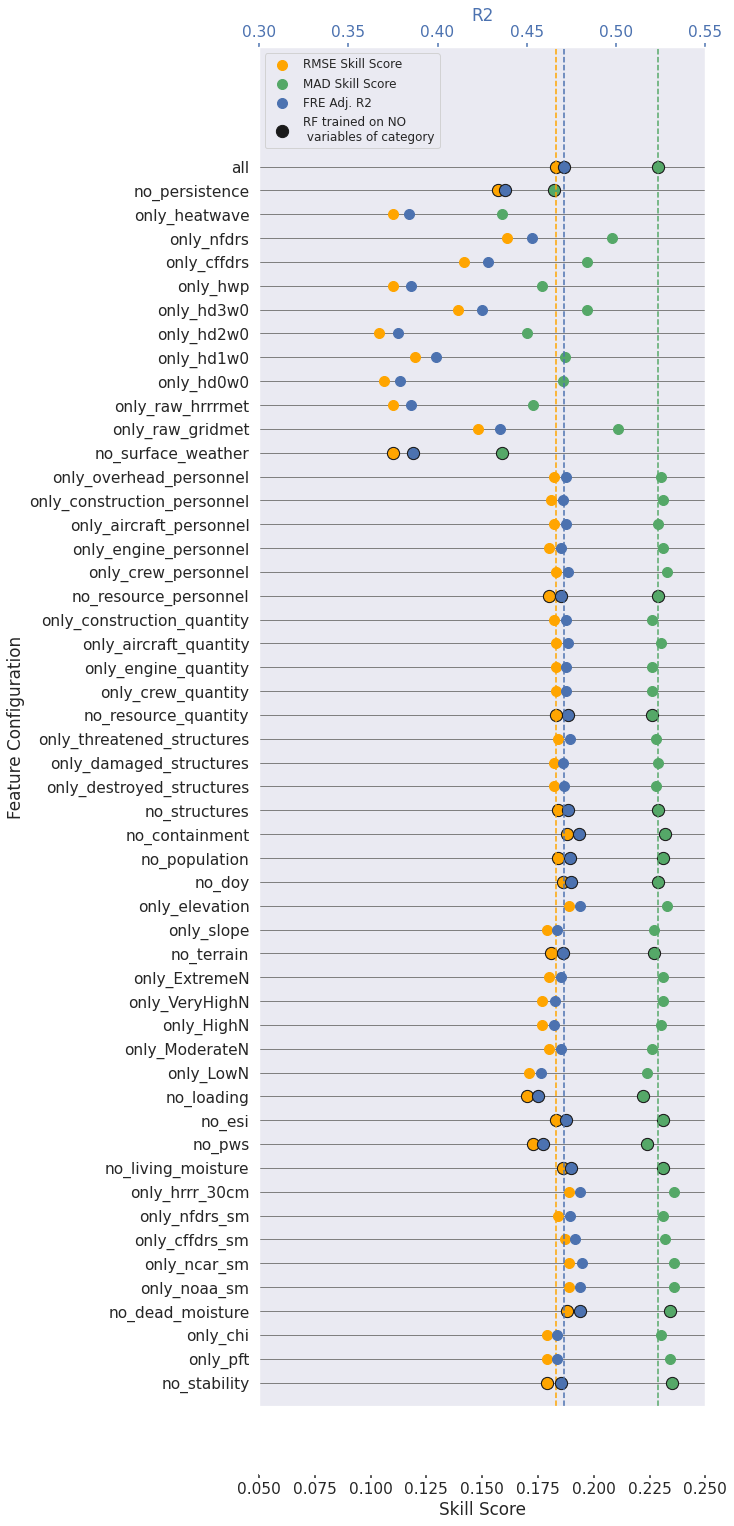

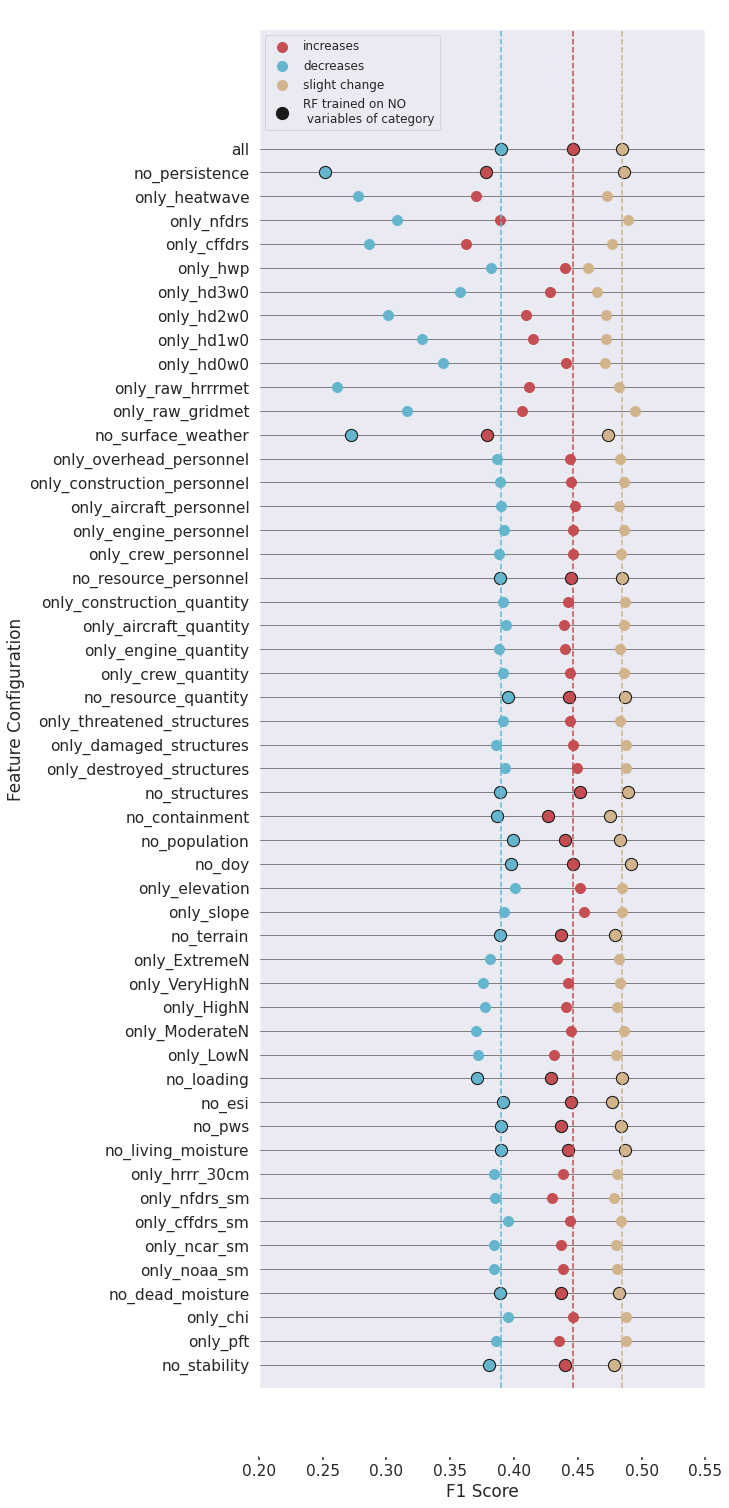

"df_error_metrics_rf_rounded = round(df_error_metrics_rf.astype('float64'),3)\nprint(df_error_metrics_rf_rounded)\ndf_error_metrics_rf_rounded.to_csv('error_fig2_hrrrmoisturte.csv')"

In [118]:
# every sensitivity test in one figure, 8/11
all_sensitivity_tests = [ #tier 2
                         'no_stability', #stabiity
                         'only_pft', 'only_chi',
                         'no_dead_moisture', #dead
                         'only_noaa_sm','only_ncar_sm',
                     'only_cffdrs_sm', 'only_nfdrs_sm',
                         'only_hrrr_30cm',
                         'no_living_moisture', #living
                        'no_pws', 'no_esi', #water stress
                         'no_loading', #loading
                         'only_LowN','only_ModerateN','only_HighN',
                         'only_VeryHighN', 'only_ExtremeN',
                         'no_terrain', #terrain
                         'only_slope', 'only_elevation',
                         'no_doy', #doy
                        'no_population','no_containment', #pop and containment
                         'no_structures', #structures
                     'only_destroyed_structures', 'only_damaged_structures','only_threatened_structures',
                     'no_resource_quantity', #resource quantity
                         'only_crew_quantity', 'only_engine_quantity','only_aircraft_quantity', 
                     'only_construction_quantity',
                         'no_resource_personnel', #resource personnel
                     'only_crew_personnel', 'only_engine_personnel','only_aircraft_personnel', 
                     'only_construction_personnel','only_overhead_personnel', 
                         'no_surface_weather', #weather
                         'only_raw_gridmet','only_raw_hrrrmet', 
                    'only_hd0w0','only_hd1w0',
                    'only_hd2w0','only_hd3w0', 'only_hwp',
                    'only_cffdrs', 'only_nfdrs', 'only_heatwave',
                    'no_persistence', #persistence

                        'all']

no_category_sensitivity_tests=['all',
                         'no_persistence', #persistence
                         'no_surface_weather', #weather
                         'no_stability', #stabiity
                         'no_living_moisture', #living
                         'no_dead_moisture', #dead
                        'no_pws', 'no_esi', #water stress
                         'no_loading', #loading
                         'no_terrain', #terrain
                         'no_doy', #doy
                        'no_population','no_containment', #pop and containment
                         'no_structures', #structures
                     'no_resource_quantity', #resource quantity
                         'no_resource_personnel',] #resource personnel']

df_error_metrics_rf = pd.read_csv('error_fig4.csv')#.set_index('Unnamed: 0')
df_error_metrics_rf['Feature_Configs'] = ''
#print(df_error_metrics_rf)
for ii in range(len(df_error_metrics_rf['Unnamed: 0'].values)):
    name = df_error_metrics_rf['Unnamed: 0'].values[ii]
    #print(name + " " + name.replace('features_',''))
    df_error_metrics_rf['Feature_Configs'].iloc[ii]=name.replace('features_','')
    
df_error_metrics_rf = df_error_metrics_rf.set_index('Feature_Configs')

plot_frp_sensitivity_metrics(df_error_metrics_rf, all_sensitivity_tests, no_category_sensitivity_tests,'all',(8,25),0.3, 0.05, 56)
plot_f1_sensitivity_metrics(df_error_metrics_rf, all_sensitivity_tests, no_category_sensitivity_tests,'all',(8,25),0.2, 56)


"""df_error_metrics_rf_rounded = round(df_error_metrics_rf.astype('float64'),3)
print(df_error_metrics_rf_rounded)
df_error_metrics_rf_rounded.to_csv('error_fig2_hrrrmoisturte.csv')"""

In [169]:
df_error_metrics = pd.read_csv('error_fig4.csv')
df_error_metrics[['Unnamed: 0','FRE_R2_adj', 'percent_change_FRE_RMSE', 'percent_change_FRE_MAD', 'increase_f1', 'decrease_f1', 'no_change_f1']]

,Unnamed: 0,FRE_R2_adj,percent_change_FRE_RMSE,percent_change_FRE_MAD,increase_f1,decrease_f1,no_change_f1
0,persistence,0.249,0.000,0.000,0.000,0.000,0.488
1,features_all,0.471,0.183,0.229,0.446,0.390,0.485
2,features_no_persistence,0.438,0.157,0.182,0.378,0.252,0.486
3,features_no_surface_weather,0.386,0.110,0.159,0.379,0.272,0.474
4,features_no_stability,0.469,0.179,0.235,0.440,0.380,0.478
5,features_no_living_moisture,0.475,0.186,0.231,0.442,0.390,0.487
6,features_no_dead_moisture,0.480,0.188,0.234,0.437,0.389,0.482
7,features_no_pws,0.459,0.173,0.224,0.437,0.390,0.484
8,features_no_esi,0.472,0.183,0.231,0.445,0.391,0.477
9,features_no_loading,0.456,0.170,0.222,0.429,0.371,0.485


In [ ]:
df_error_metrics_rf = pd.read_csv('error_fig2_hrrrmoisturte.csv')
#df_error_metrics_rf
df_error_metrics_rf[['Unnamed: 0', 'FRE_R2_adj', 'percent_change_FRE_RMSE', 'percent_change_FRE_MAD', 'increase_f1', 'decrease_f1', 'no_change_f1']]

In [ ]:
df_error_metrics_rf = pd.read_csv('error_fig2_hrrrmoisture.csv')
#df_error_metrics_rf
df_error_metrics_rf[['Unnamed: 0', 'FRE_R2_adj', 'percent_change_FRE_RMSE', 'percent_change_FRE_MAD', 'increase_f1', 'decrease_f1', 'no_change_f1']]

# Figure 2

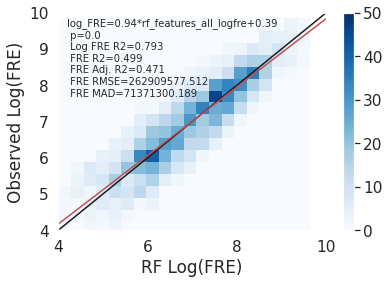

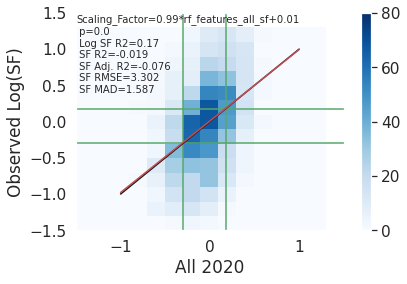

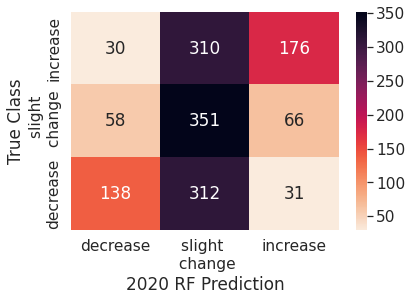

              precision    recall  f1-score   support

    decrease       0.61      0.29      0.39       481
    increase       0.64      0.34      0.45       516
   no_change       0.36      0.74      0.48       475

    accuracy                           0.45      1472
   macro avg       0.54      0.46      0.44      1472
weighted avg       0.54      0.45      0.44      1472



In [122]:
# Plotting
for ii in range(1,len(feature_set_names)):

    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_fre', 'FRE','rf_'+feature_set_names[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,'RF Log(FRE)',feature_subsets[feature_set_names[ii]])
    
    sf_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor','Blues',0,80, -.3, .18, 'All 2020',feature_subsets[feature_set_names[ii]])
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  



In [168]:
df_error_metrics = pd.read_csv('error_fig2_scaled.csv')
df_error_metrics[['Unnamed: 0','FRE_R2_adj', 'percent_change_FRE_RMSE', 'percent_change_FRE_MAD', 'increase_f1', 'decrease_f1', 'no_change_f1']]

,Unnamed: 0,FRE_R2_adj,percent_change_FRE_RMSE,percent_change_FRE_MAD,increase_f1,decrease_f1,no_change_f1
0,persistence,0.25,0.00,0.00,0.00,0.00,0.49
1,dwind_speed_gridmet,0.17,-0.05,0.02,0.17,0.05,0.47
2,dvpd_gridmet,0.33,0.05,0.05,0.12,0.04,0.49
3,dwind_speed_hrrrmet,0.33,0.05,0.03,0.22,0.09,0.47
4,dvpd_hrrrmet,0.37,0.08,0.06,0.06,0.02,0.49
5,dmax_air_temperature,0.24,-0.01,-0.01,0.00,0.00,0.49
6,dhwp,-0.60,-0.46,0.01,0.37,0.22,0.49
7,dhd0w0,0.40,0.10,0.12,0.24,0.11,0.48
8,dhd1w0,0.29,0.02,0.06,0.27,0.09,0.48
9,dhd2w0,0.28,0.02,0.04,0.24,0.10,0.48


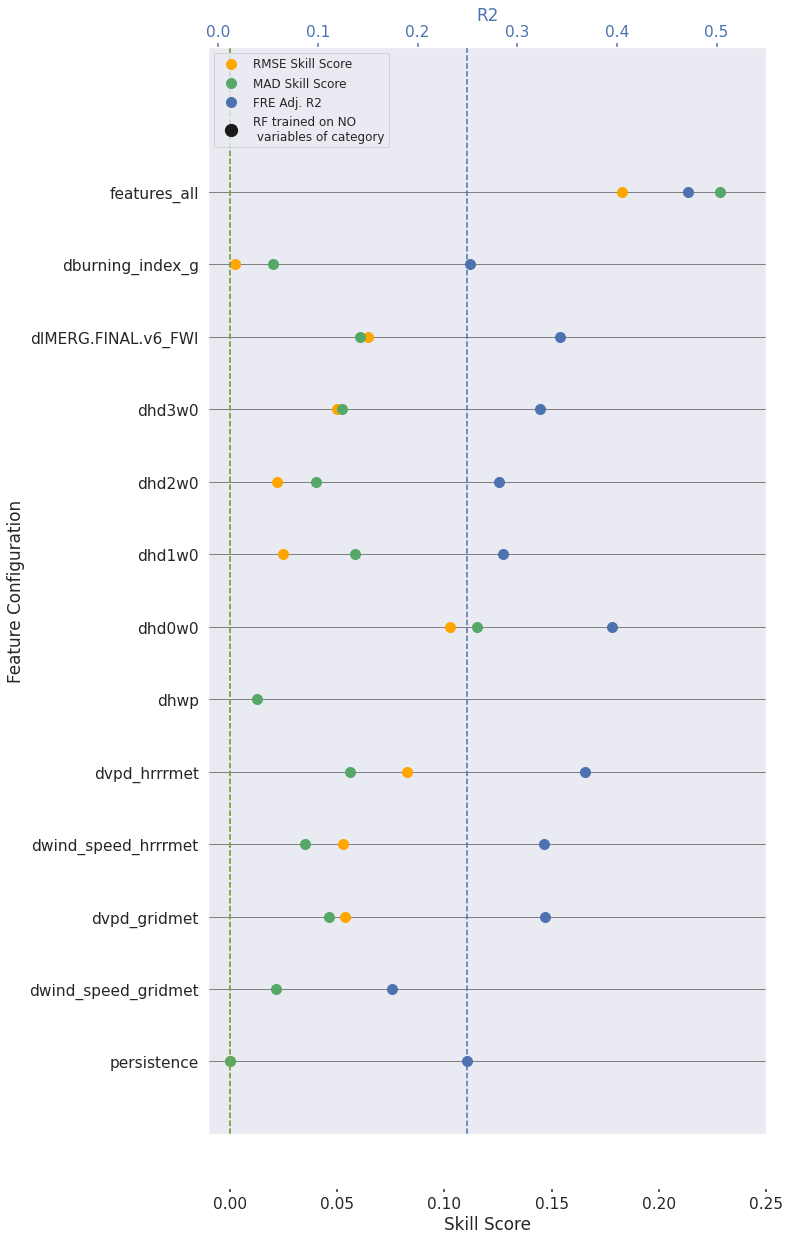

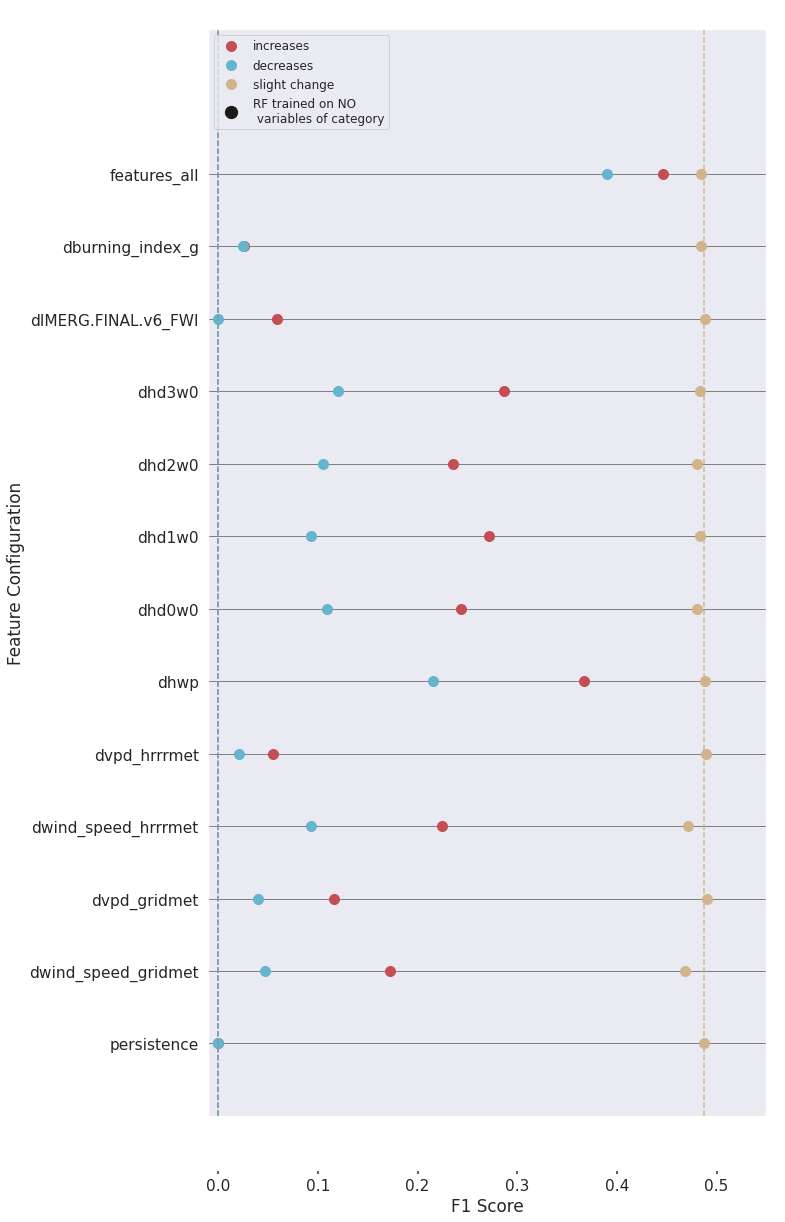

In [133]:
#SCALED METHODS, NO EUREQA
all_sensitivity_tests = ['persistence','dwind_speed_gridmet','dvpd_gridmet','dwind_speed_hrrrmet','dvpd_hrrrmet',
                          'dhwp',
                         'dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',#'dIMERG.FINAL.v6_BUI',
                         'dburning_index_g',#'denergy_release_component-g',
                         'features_all']


df_error_metrics = pd.concat([df_error_metrics_scaled, 
                              df_error_metrics_rf.iloc[1:2,:]])#.drop(columns='Unnamed: 0')])

#df_error_metrics = pd.read_csv('error_fig1.csv')
#round the error metrics
df_error_metrics_rounded = round(df_error_metrics.astype('float64'),2)
plot_frp_sensitivity_metrics(df_error_metrics, all_sensitivity_tests,[],'persistence', (10,20), -0.01, -0.01, 14)
plot_f1_sensitivity_metrics(df_error_metrics, all_sensitivity_tests,[],'persistence',(10,20), -0.01, 14)
#print(df_error_metrics_rounded)
#df_error_metrics_rounded.to_csv('error_fig2_scaled.csv')

# Forecastable variables test (10/6)

In [22]:
feature_subsets = {}

#all features
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

feature_subsets['features_soilm_sfc'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_sfc',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_soilm_1cm'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_1cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_soilm_4cm'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_4cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_soilm_10cm'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_10cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
#previously called features_soilm_30cm
feature_subsets['features_hrrrmet_hwp'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_can_hwp'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                   'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_us_hwp'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_gridmet_hwp'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_hrrrmet_hwp'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]

feature_subsets['features_can_hdw'] = ['IMERG.FINAL.v6_FWI', 'dIMERG.FINAL.v6_FWI',
                                  'IMERG.FINAL.v6_BUI', 'dIMERG.FINAL.v6_BUI',
                                    'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_us_hdw'] = ['burning_index_g', 'dburning_index_g',
                                   'energy_release_component-g', 'denergy_release_component-g',
                                  'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                    'dead_fuel_moisture_100hr', 'dead_fuel_moisture_1000hr',
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_gridmet_hdw'] = ['vpd_gridmet', 'dvpd_gridmet',
                                           'wind_speed_gridmet','dwind_speed_gridmet',
                                  'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                   "IMERG.FINAL.v6_FFMC", "IMERG.FINAL.v6_DMC", "IMERG.FINAL.v6_DC",
                                   'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]
feature_subsets['features_hrrrmet_hdw'] = ['vpd_hrrrmet', 'dvpd_hrrrmet',
                                    'wind_speed_hrrrmet','dwind_speed_hrrrmet',
                                      'hd0w0','dhd0w0',
                                   'PFT', 'dPFT', 
                                    'soilm_30cm',
                                    'PWS','Extreme_N',
                                   'MEAN_ELEV', 'STD_ELEV',
                                    'structures_threatened_72_1','air_quantity_1',
                                   'FRE_1' ]


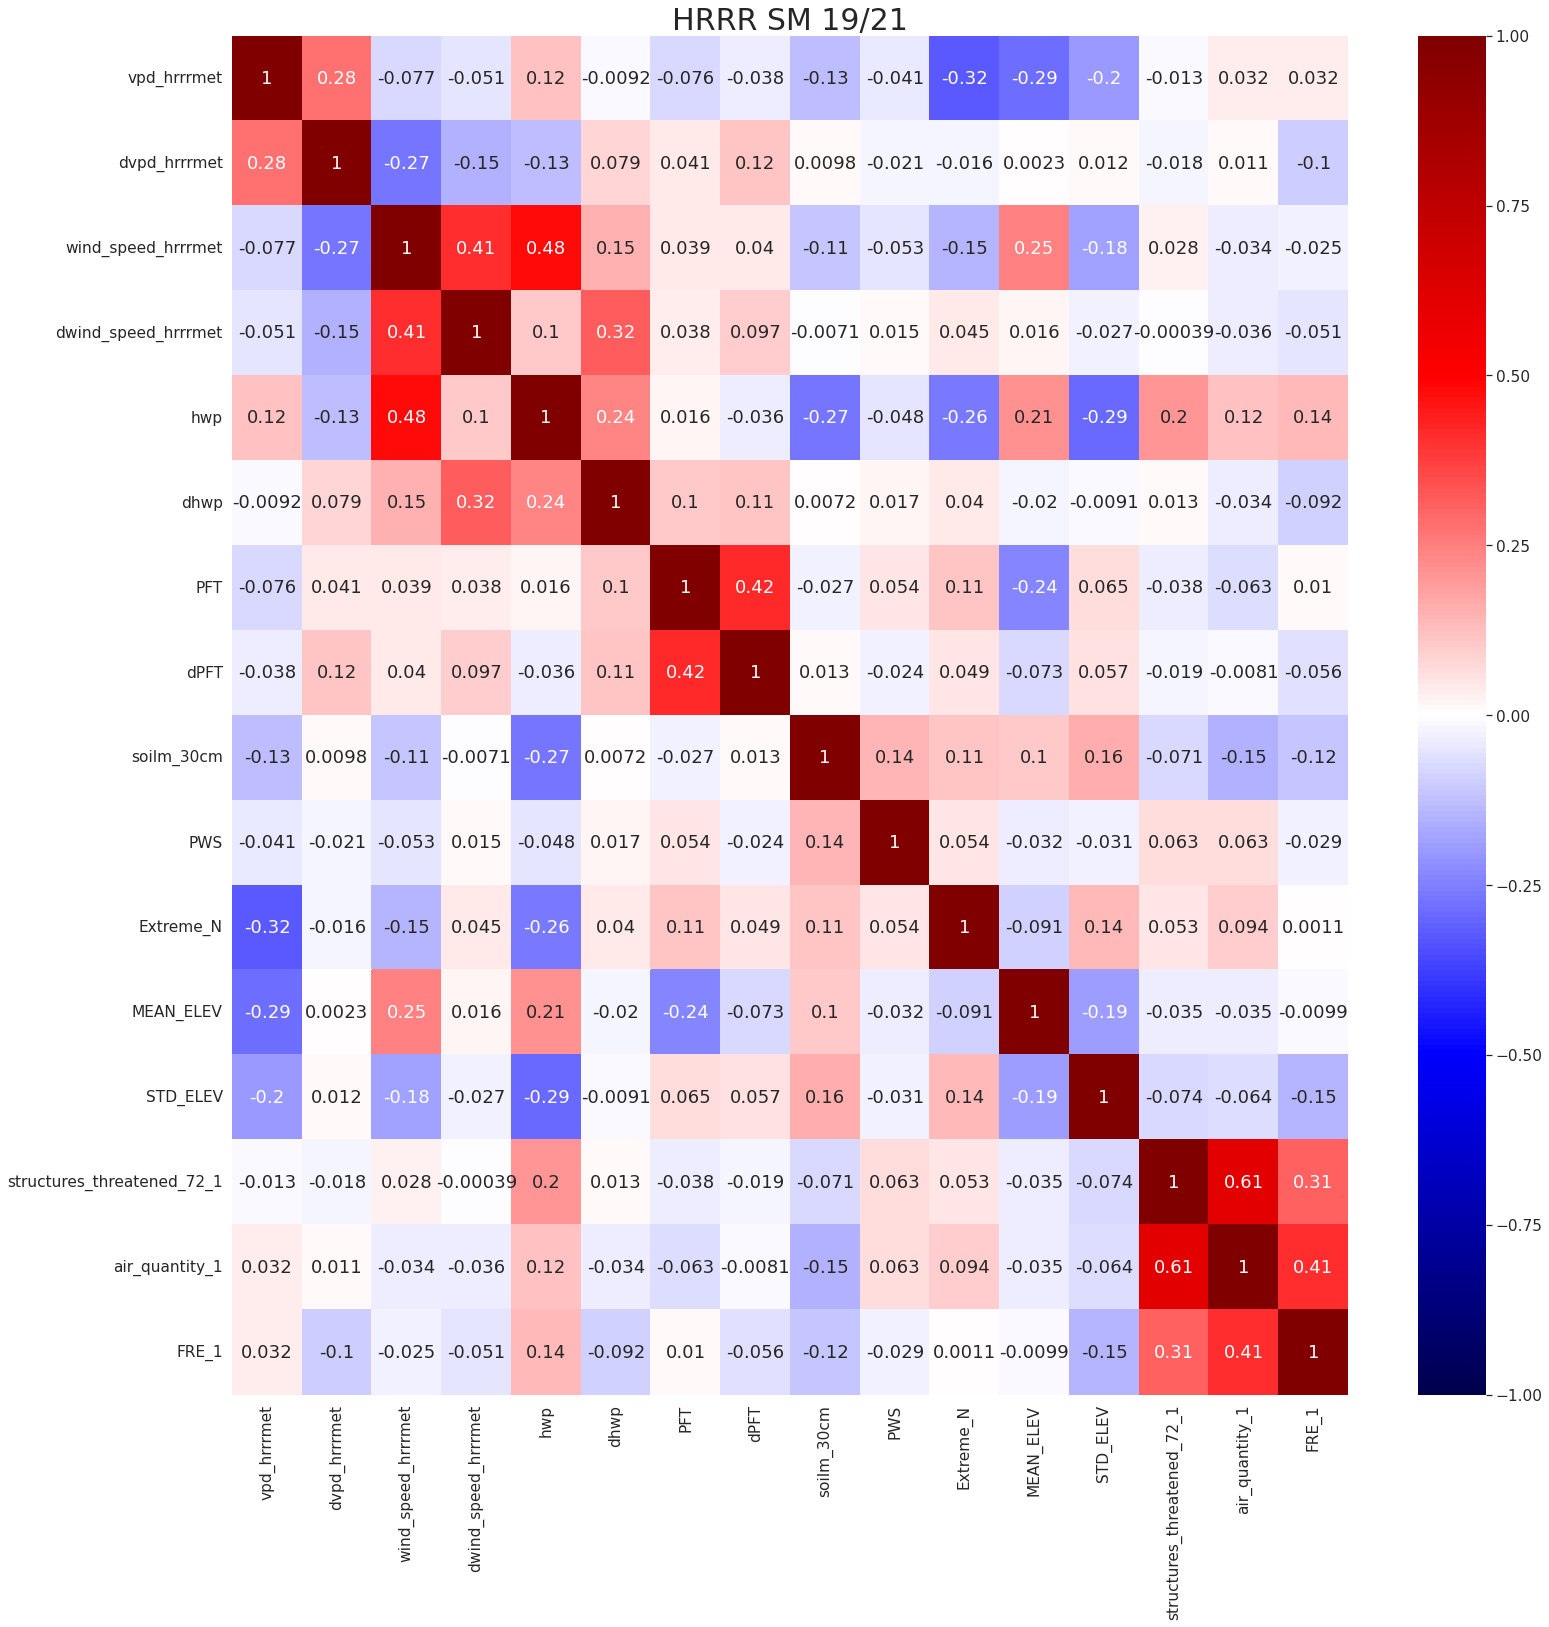

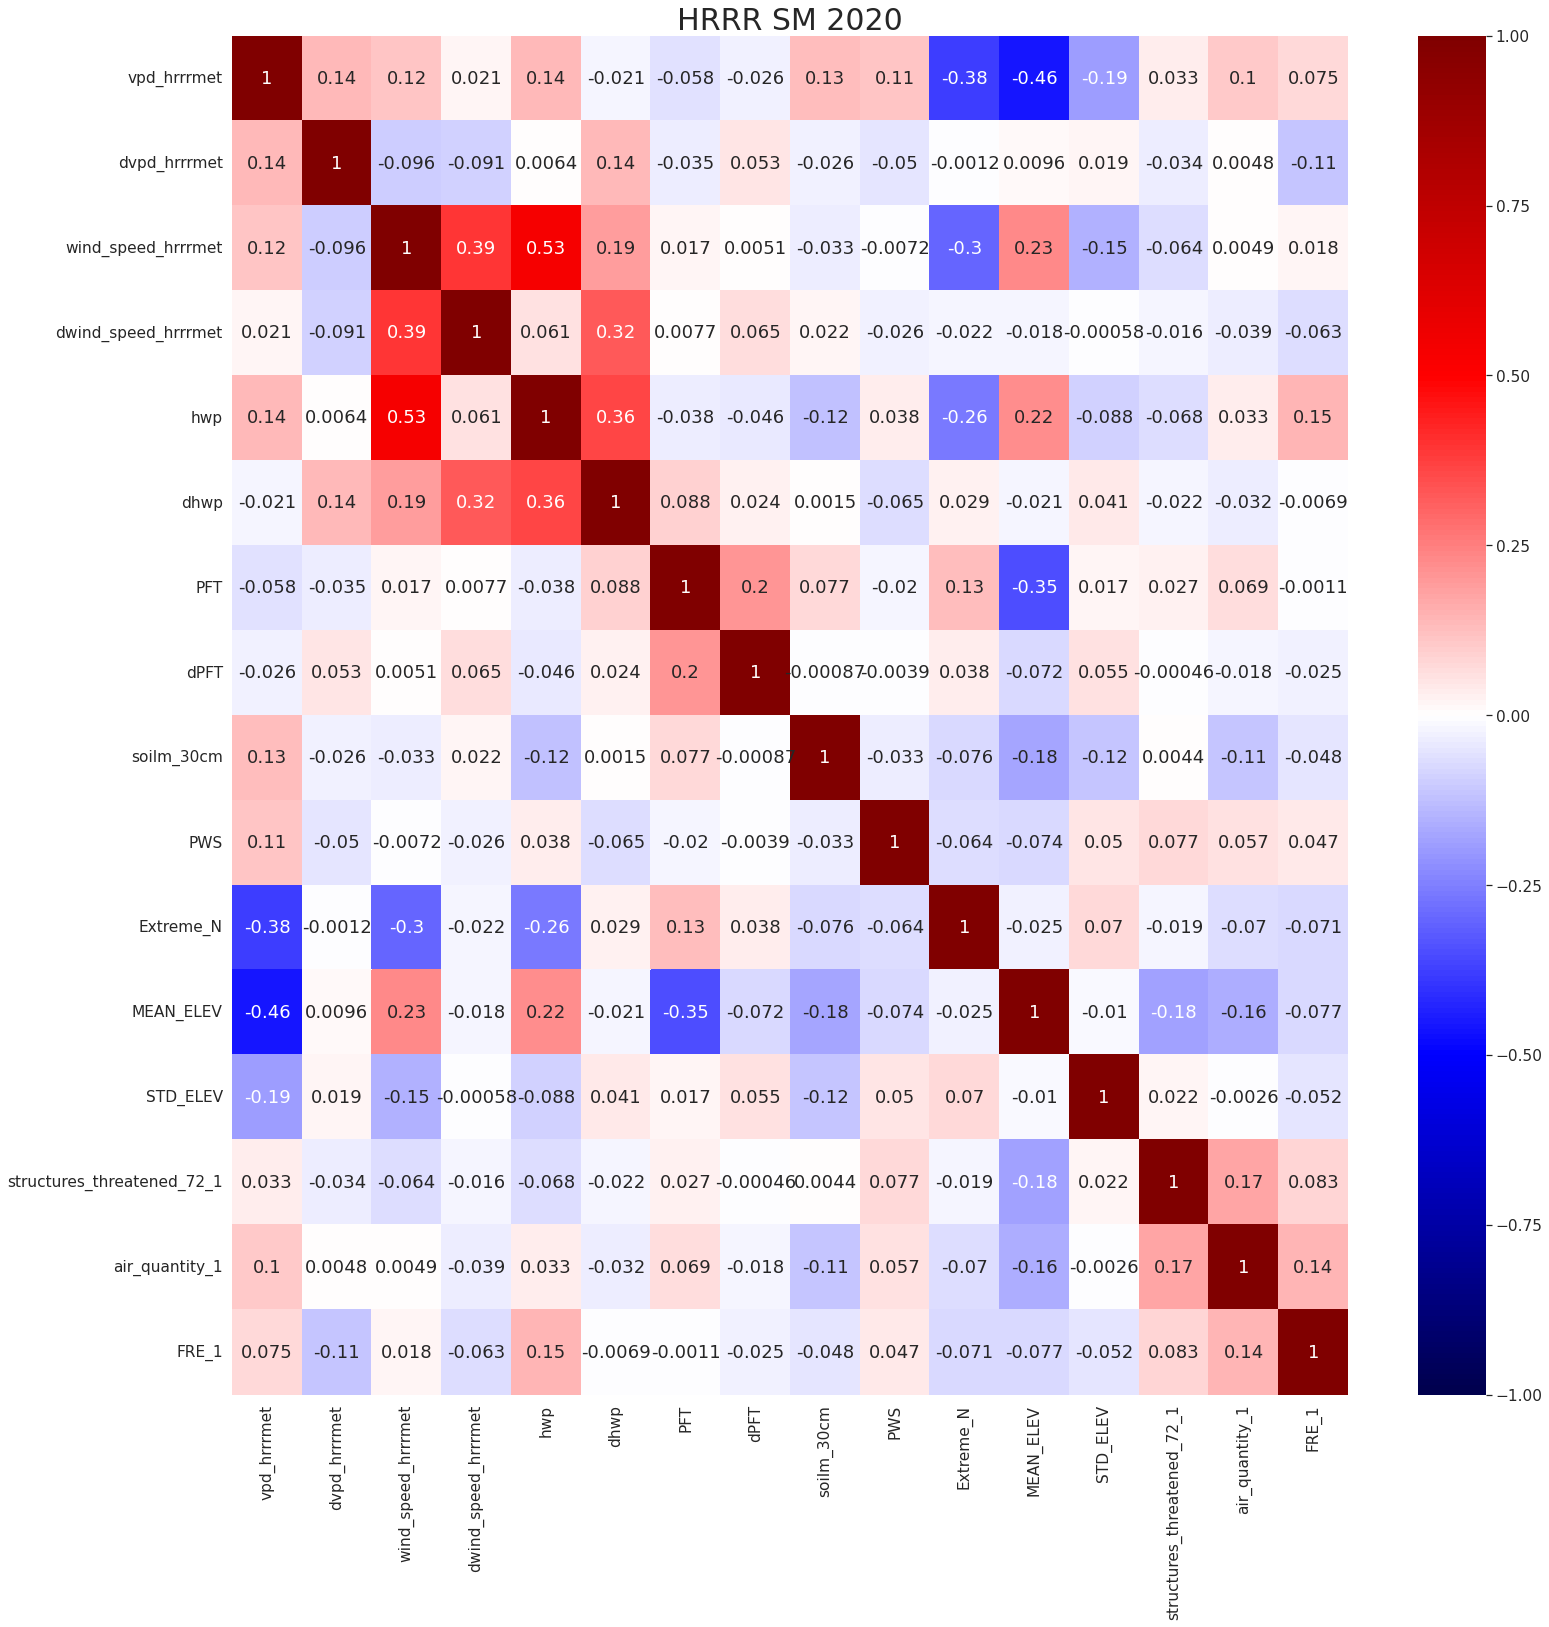

In [143]:
plot_correlations(data_train_1921[feature_subsets['features_hrrrmet_hwp']],
                  'HRRR SM 19/21','pearson', 18, (25,25))

plot_correlations(data_test_2020[feature_subsets['features_hrrrmet_hwp']],
                  'HRRR SM 2020','pearson', 18, (25,25))

In [ ]:
print(feature_subsets['features_all'])

In [25]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5


feature_set_names = ['persistence','features_all','features_soilm_sfc', 
                     #'features_soilm_1cm', 'features_soilm_4cm', 'features_soilm_10cm', 
                     'features_hrrrmet_hwp',
                     'features_can_hwp', 'features_us_hwp', 'features_gridmet_hwp',
                     'features_hrrrmet_hdw',
                     'features_can_hdw', 'features_us_hdw', 'features_gridmet_hdw',
                    ]


df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5)
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])
    
    if feature_set_names[ii] =='features_hrrrmet_hwp':
        gsearch.feature_names = feature_subsets[feature_set_names[ii]]
        joblib.dump(gsearch, feature_set_names[ii]+'.sav')

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    #plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
    
    
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

features_all OOB R2 score is: 0.22050534046478187
features_soilm_sfc OOB R2 score is: 0.1981287646941916
features_hrrrmet_hwp OOB R2 score is: 0.19851169708137506
features_can_hwp OOB R2 score is: 0.16638057451739918
features_us_hwp OOB R2 score is: 0.17334136340772854
features_gridmet_hwp OOB R2 score is: 0.21678631941284887
features_hrrrmet_hdw OOB R2 score is: 0.16035528959562173
features_can_hdw OOB R2 score is: 0.1423156708123412
features_us_hdw OOB R2 score is: 0.16422663207684762
features_gridmet_hdw OOB R2 score is: 0.17172432444373043
DOING PERSISTENCE


### add in the ensemble prediction

In [25]:
#make predictions for all of the holdout year (2020)
ensemble_members = ['rf_features_us_hwp_logsf', 'rf_features_can_hwp_logsf', 
                    'rf_features_gridmet_hwp_logsf', 'rf_features_hrrrmet_hwp_logsf']

data_test_2020['rf_ensemble_logsf'] = data_test_2020[ensemble_members].mean(axis=1)

data_test_2020['rf_ensemble_sf'] = 10**(data_test_2020['rf_ensemble_logsf'])
data_test_2020['rf_ensemble_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_ensemble_sf']
data_test_2020['rf_ensemble_logfre'] = np.log10(data_test_2020['rf_ensemble_fre'])
data_test_2020['rf_ensemble_cat'] = pd.cut(data_test_2020['rf_ensemble_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

#compute the metrics
errors_fre = summarize_error(data_test_2020,'FRE', 'rf_ensemble_fre',ensemble_members)
errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_ensemble_logfre',ensemble_members)
errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_ensemble_sf',ensemble_members)
errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_ensemble_logsf',ensemble_members)
cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_ensemble_cat'], output_dict=True))
    
#put the metrics in their home in the metrics table
df_error_metrics_rf.loc['ensemble',['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
df_error_metrics_rf.loc['ensemble',['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
df_error_metrics_rf.loc['ensemble',['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
df_error_metrics_rf.loc['ensemble',['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
df_error_metrics_rf.loc['ensemble', 'decrease_precision'] = cr.loc['precision', 'decrease']
df_error_metrics_rf.loc['ensemble', 'decrease_recall'] = cr.loc['recall', 'decrease']
df_error_metrics_rf.loc['ensemble', 'decrease_f1'] = cr.loc['f1-score', 'decrease']
df_error_metrics_rf.loc['ensemble', 'increase_precision'] = cr.loc['precision', 'increase']
df_error_metrics_rf.loc['ensemble', 'increase_recall'] = cr.loc['recall', 'increase']
df_error_metrics_rf.loc['ensemble', 'increase_f1'] = cr.loc['f1-score', 'increase']

df_error_metrics_rf.loc['ensemble', 'no_change_precision'] = cr.loc['precision', 'no_change']
df_error_metrics_rf.loc['ensemble', 'no_change_recall'] = cr.loc['recall', 'no_change']
df_error_metrics_rf.loc['ensemble', 'no_change_f1'] = cr.loc['f1-score', 'no_change']
df_error_metrics_rf.loc['ensemble', 'accuracy'] = cr.loc['precision', 'accuracy']

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']



In [26]:
feature_plot_names = ['persistence','features_all',
                     'features_us_hwp', 'features_can_hwp', 'features_gridmet_hwp', 'features_hrrrmet_hwp',
                    'ensemble']
plot_frp_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[], 'features_all',(10,8), -.01,  -.01,9)
plot_f1_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[],'features_all',(10,8),  -.01,9)
print(df_error_metrics_rf)

NameError: name 'plot_frp_sensitivity_metrics' is not defined

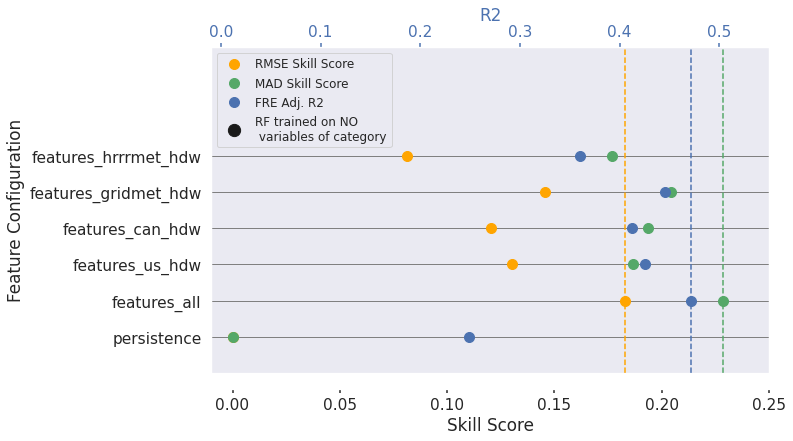

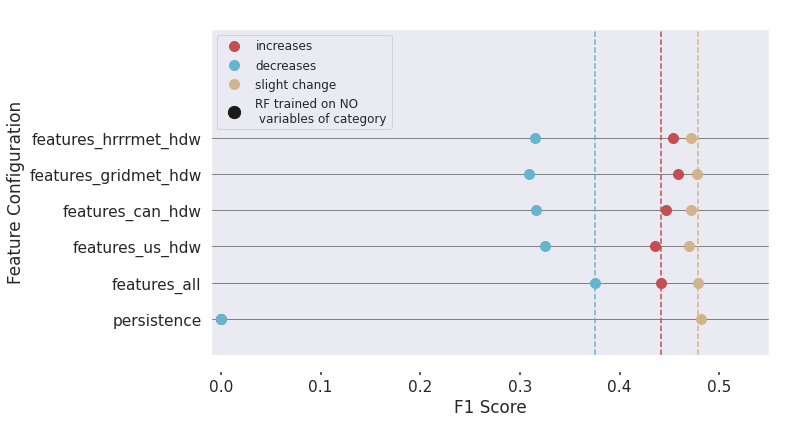

                        FRE_R2 FRE_R2_adj          FRE_RMSE          FRE_MAD  \
persistence           0.249789   0.249278  321690675.692184  92521743.965657   
features_all          0.498906   0.471227  262909577.512393  71371300.189499   
features_soilm_sfc    0.434633   0.428416  279261971.158445   73667406.62136   
features_hrrrmet_hwp  0.477033   0.471282  268586387.626208  72489047.262566   
features_can_hwp       0.50978   0.503707  260041209.588021  71779836.505619   
features_us_hwp       0.538514   0.533118  252305153.515733  70638014.421923   
features_gridmet_hwp  0.525618   0.519741  255806123.709891  70944342.842865   
features_hrrrmet_hdw  0.367006   0.360045   295492503.64267   76174190.75309   
features_can_hdw      0.419566   0.412375  282958811.715476  74613584.816593   
features_us_hdw       0.432256   0.425618  279848477.180088  75243846.506006   
features_gridmet_hdw  0.452412   0.445628  274836110.176573  73614702.832861   

                     log_FRE_R2 log_FRE

In [147]:
feature_plot_names = ['persistence','features_all',
                     'features_us_hdw', 'features_can_hdw', 'features_gridmet_hdw', 'features_hrrrmet_hdw'
                    ]
plot_frp_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[], 'features_all',(10,6), -.01,  -.01, 8)
plot_f1_sensitivity_metrics(df_error_metrics_rf, feature_plot_names,[],'features_all',(10,6),  -.01, 8)
print(df_error_metrics_rf)

# Test HDW 500m vs surface definition

In [ ]:
#LOAD IN THE FEATURE CSV
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weighted.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)


In [ ]:
#LOAD IN THE FEATURE CSV WITH HDW500
features_no_outliers_weighted = pd.read_csv('features_no_outliers_weightedHDW500.csv',
                                           parse_dates=['datetime'])
features_no_outliers_weighted=features_no_outliers_weighted.drop(columns=['Unnamed: 0'])
#print(features_no_outliers_weighted.columns.values)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
#data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

In [ ]:
data_train_1921['obs_cat'] = pd.cut(data_train_1921['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, -.18, .3, 10],
                                            labels=['decrease','no_change','increase'])
print(len(data_train_1921))
print(str(len(data_train_1921[data_train_1921['obs_cat']=='decrease'])) + ' decreases')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='no_change'])) + ' slight changes')
print(str(len(data_train_1921[data_train_1921['obs_cat']=='increase'])) + ' increases')

In [ ]:
#PERSISTENCE AND SCALED METHODS

scaled_methods = ['persistence','dhd0w0'] 

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

df_error_metrics_scaled = pd.DataFrame(index=scaled_methods, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',
                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#do the plottint
#drop the nans, these will show up in the scaled methods

data_test_2020= data_test_2020.iloc[np.where((data_test_2020['dhwp']<21.4)&(data_test_2020['dhwp']>0.04)&
                                            (data_test_2020['dhd0w0']<21.4)&(data_test_2020['dhd0w0']>0.04)&
                                            (data_test_2020['dhd1w0']<21.4)&(data_test_2020['dhd1w0']>0.04)&
                                            (data_test_2020['dhd2w0']<21.4)&(data_test_2020['dhd2w0']>0.04)&
                                            (data_test_2020['dhd3w0']<21.4)&(data_test_2020['dhd3w0']>0.04)&
                                            (data_test_2020['dwind_speed_gridmet']<21.4)&(data_test_2020['dwind_speed_gridmet']>0.04)&
                                            (data_test_2020['dvpd_gridmet']<21.4)&(data_test_2020['dvpd_gridmet']>0.04)&
                                            (data_test_2020['dwind_speed_hrrrmet']<21.4)&(data_test_2020['dwind_speed_hrrrmet']>0.04)&
                                            (data_test_2020['dvpd_hrrrmet']<21.4)&(data_test_2020['dvpd_hrrrmet']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_FWI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_FWI']>0.04)&
                                            (data_test_2020['dIMERG.FINAL.v6_BUI']<21.4)&(data_test_2020['dIMERG.FINAL.v6_BUI']>0.04)&
                                            (data_test_2020['dburning_index_g']<21.4)&(data_test_2020['dburning_index_g']>0.04)&
                                            (data_test_2020['denergy_release_component-g']<21.4)&(data_test_2020['denergy_release_component-g']>0.04))]
print(len(data_test_2020))

#do the calculations
for ii in range(len(scaled_methods)):
    #print(scaled_methods[ii])
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfre'] = np.log10(data_test_2020[scaled_methods[ii]+'_fre'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
#print(data_test_2020.columns.values)    
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))


#get the error metrics
for ii in range(len(scaled_methods)):
    if scaled_methods[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', scaled_methods[ii]+'_fre',[scaled_methods[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', scaled_methods[ii]+'_logfre',[scaled_methods[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', scaled_methods[ii]+'_sf',[scaled_methods[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', scaled_methods[ii]+'_logsf',[scaled_methods[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020[scaled_methods[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_scaled.loc[scaled_methods[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_scaled.loc[scaled_methods[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_scaled.loc[scaled_methods[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_scaled.loc[scaled_methods[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_scaled['percent_change_FRE_RMSE'] = (df_error_metrics_scaled.loc['persistence','FRE_RMSE']-df_error_metrics_scaled['FRE_RMSE'])/df_error_metrics_scaled.loc['persistence','FRE_RMSE']
df_error_metrics_scaled['percent_change_FRE_MAD'] = (df_error_metrics_scaled.loc['persistence','FRE_MAD']-df_error_metrics_scaled['FRE_MAD'])/df_error_metrics_scaled.loc['persistence','FRE_MAD']


df_error_metrics_scaled['percent_change_SF_RMSE'] = (df_error_metrics_scaled.loc['persistence','SF_RMSE']-df_error_metrics_scaled['SF_RMSE'])/df_error_metrics_scaled.loc['persistence','SF_RMSE']
df_error_metrics_scaled['percent_change_SF_MAD'] = (df_error_metrics_scaled.loc['persistence','SF_MAD']-df_error_metrics_scaled['SF_MAD'])/df_error_metrics_scaled.loc['persistence','SF_MAD']

    

#persistence
frp_hist2d(data_test_2020, 'FRE_1', 'FRE','log_FRE_1', 'log_FRE', 'Blues', 0, 50,'Persistence Log(FRE)',['persistence'])
sf_hist2d(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor','Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,'Persistence Log(SF)',['persistence'])
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 Persistence Prediction') 



for ii in range(len(scaled_methods)):
    print(scaled_methods[ii])
    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, scaled_methods[ii]+'_fre', 'FRE',scaled_methods[ii]+'_logfre', 'log_FRE', 'Blues', 0, 50,scaled_methods[ii]+' Log(FRE)',scaled_methods[ii])
    sf_hist2d(data_test_2020, scaled_methods[ii]+'_sf', 'Scaling_Factor',scaled_methods[ii]+'_logsf', 'Log_Scaling_Factor', 'Blues', 0, 80,thresh_inc, thresh_dec,scaled_methods[ii]+' Log(SF)',scaled_methods[ii])
    plot_category_heatmap(data_test_2020, 'obs_cat', scaled_methods[ii]+'_cat', '2020 '+scaled_methods[ii]+' Prediction')  


In [ ]:
features_by_category = {'raw_weather_gridmet':["vpd_gridmet","wind_speed_gridmet","dvpd_gridmet","dwind_speed_gridmet"],
                    'temperatures_gridmet':["max_air_temperature","min_air_temperature","temp_range"], 
                   'raw_weather_hrrr':["vpd_hrrrmet","wind_speed_hrrrmet","dvpd_hrrrmet","dwind_speed_hrrrmet"],
                   'heatwave':["days_in_high_heatwave","days_in_highlow_heatwave","min_air_temperature","max_air_temperature"],
                   'derived_weather_hwp': ["hwp","dhwp"],
                   'derived_weather_hdw': ["dhd0w0","dhd1w0", "dhd2w0", "dhd3w0","hd0w0", "hd1w0", "hd2w0", "hd3w0"],
                   'derived_weather_cffrds': [ "dIMERG.FINAL.v6_FWI","dIMERG.FINAL.v6_BUI", "IMERG.FINAL.v6_FWI","IMERG.FINAL.v6_BUI"],
                   'derived_weather_nfdrs':[ "dburning_index_g","denergy_release_component-g","burning_index_g","energy_release_component-g"],
                   'stability': ["PFT", "chi","dchi", "dPFT"],
                    'living_moisture':['FMCGLH2D'],
                    'thin_moisture': ['Blended_SM', 'FMCG2D', 'IMERG.FINAL.v6_FFMC'],
                    'mid_moisture':['IMERG.FINAL.v6_DMC', 'dead_fuel_moisture_100hr'],
                    'thick_moisture':['IMERG.FINAL.v6_DC','dead_fuel_moisture_1000hr'],
                   'pws':["PWS"],
                   'esi':["ESI"],
                   'loading': ["Low_N", "Moderate_N", "High_N", "VeryHigh_N", "Extreme_N"],
                   'terrain_slope': ["MEAN_SLOPE","STD_SLOPE"],
                   'terrain_elevation': ["MEAN_ELEV","STD_ELEV"],
                   'DOY': ['DOY'],
                   'containment': ["percent_contained_1"],
                   'resource_personnel': ["crew_personnel_1","engine_personnel_1","air_personnel_1","construction_personnel_1","overhead_personnel_1"],
                   'resource_quantity': ["crew_quantity_1", "engine_quantity_1",  "air_quantity_1", "construction_quantity_1"],
                   'pop': ["POP_DENSITY"],
                   'structures': ["structures_destroyed_1", "structures_damaged_1","structures_threatened_72_1"],
                   'persistence': ["FRE_1"]}
category_list = features_by_category.keys()

feature_subsets = {}
not_allowed=[]
feature_subsets['features_all'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], [])

not_allowed = ['raw_weather_gridmet','temperature_gridmet','raw_weather_hrrr','heatwave','derived_weather_hwp','derived_weather_hdw',
                 'derived_weather_cffrds','derived_weather_nfdrs']
feature_subsets['features_only_hd0w0'] = generate_sensitivity_list(features_by_category, [var for var in category_list if var not in not_allowed], ["hd0w0","dhd0w0"])


feature_subsets['features_hdw'] = ['hd0w0','dhd0w0',
                                   'hwp','dhwp',
                                   'PFT', 'dPFT', 
                                    'Blended_SM',  'FMCG2D', 'FMCGLH2D','PWS','Moderate_N','DOY',
                                    'POP_DENSITY', 'percent_contained_1', 'structures_destroyed_1','engine_personnel_1',
                                   'FRE_1' ]

In [ ]:
# RANDOM FOREST METHOD
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all', 'features_only_hd0w0', 'features_hdw']

df_error_metrics_rf = pd.DataFrame(index=feature_set_names, 
                                columns=['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD',
                                         'log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD',
                                        'SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD',
                                        'log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD',

                                        'decrease_precision', 'decrease_recall', 
                                         'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])
#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5)
    #gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=10) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    #plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_fre'] = data_test_2020['FRE_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfre'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_fre'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#get the error metrics
for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors_fre = summarize_error(data_test_2020,'FRE', 'FRE_1', ['persistence'])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'log_FRE_1',['persistence'])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'persistence',['persistence'])
        errors_logsf = summarize_error(data_test_2020,'Scaling_Factor', 'log_persistence',['persistence'])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors_fre = summarize_error(data_test_2020,'FRE', 'rf_'+feature_set_names[ii]+'_fre',feature_subsets[feature_set_names[ii]])
        errors_logfre = summarize_error(data_test_2020, 'log_FRE', 'rf_'+feature_set_names[ii]+'_logfre',feature_subsets[feature_set_names[ii]])
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf',feature_subsets[feature_set_names[ii]])
        errors_logsf = summarize_error(data_test_2020, 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_logsf',feature_subsets[feature_set_names[ii]])
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics_rf.loc[feature_set_names[ii],['FRE_R2','FRE_R2_adj', 'FRE_RMSE', 'FRE_MAD']] = errors_fre
    df_error_metrics_rf.loc[feature_set_names[ii],['log_FRE_R2','log_FRE_R2_adj', 'log_FRE_RMSE', 'log_FRE_MAD']] = errors_logfre
    df_error_metrics_rf.loc[feature_set_names[ii],['SF_R2', 'SF_R2_adj', 'SF_RMSE', 'SF_MAD']] = errors_sf
    df_error_metrics_rf.loc[feature_set_names[ii],['log_SF_R2', 'log_SF_R2_adj', 'log_SF_RMSE', 'log_SF_MAD']] = errors_logsf
    
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'decrease_f1'] = cr.loc['f1-score', 'decrease']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics_rf.loc[feature_set_names[ii], 'increase_f1'] = cr.loc['f1-score', 'increase']

    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'no_change_f1'] = cr.loc['f1-score', 'no_change']
    df_error_metrics_rf.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']
#persistence

df_error_metrics_rf['percent_change_FRE_RMSE'] = (df_error_metrics_rf.loc['persistence','FRE_RMSE']-df_error_metrics_rf['FRE_RMSE'])/df_error_metrics_rf.loc['persistence','FRE_RMSE']
df_error_metrics_rf['percent_change_FRE_MAD'] = (df_error_metrics_rf.loc['persistence','FRE_MAD']-df_error_metrics_rf['FRE_MAD'])/df_error_metrics_rf.loc['persistence','FRE_MAD']


df_error_metrics_rf['percent_change_SF_RMSE'] = (df_error_metrics_rf.loc['persistence','SF_RMSE']-df_error_metrics_rf['SF_RMSE'])/df_error_metrics_rf.loc['persistence','SF_RMSE']
df_error_metrics_rf['percent_change_SF_MAD'] = (df_error_metrics_rf.loc['persistence','SF_MAD']-df_error_metrics_rf['SF_MAD'])/df_error_metrics_rf.loc['persistence','SF_MAD']

In [ ]:
df_error_metrics = pd.concat([df_error_metrics_scaled.loc[['dhd0w0'], ['FRE_R2_adj', 'percent_change_FRE_RMSE','percent_change_FRE_MAD',
                                      'increase_f1', 'decrease_f1', 'no_change_f1']], df_error_metrics_rf.loc[:,['FRE_R2_adj', 'percent_change_FRE_RMSE','percent_change_FRE_MAD',
                                      'increase_f1', 'decrease_f1', 'no_change_f1']]])
print(round(df_error_metrics.astype('float64'),2))
      
      